
## ML time series with sktime


In [1]:

## !pip install statsmodels


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



import warnings
warnings.filterwarnings('ignore')


In [3]:


import sktime
import statsmodels as sm
import matplotlib 
import sklearn

from sklearn.linear_model import( LinearRegression, 
                                 ElasticNet, 
                                 Ridge, 
                                 Lasso, 
                                 HuberRegressor)


from sktime.performance_metrics.forecasting import(MeanAbsolutePercentageError, 
                                                   MeanSquaredError, 
                                                   MeanAbsoluteScaledError)

from statsmodels.graphics.tsaplots import plot_acf



In [4]:

daily_temp = pd.read_csv('data/daily_weather.csv', 
                          index_col='DateTime', 
                          parse_dates=True
)

daily_temp.columns = ['y']

energy = pd.read_csv('data/energy_consumption.csv', 
                     index_col='Month', 
                     parse_dates=True
)

energy.columns = ['y']

air = pd.read_csv('data/air_passenger.csv', 
                  index_col='date', 
                  parse_dates=True)

air.columns = ['y']


In [5]:

daily_temp.index.freq = 'D'
energy.index.freq = 'MS'
air.index.freq = 'M'


In [6]:

print(daily_temp.index.freq)
print(energy.index.freq)
print(air.index.freq)


<Day>
<MonthBegin>
<MonthEnd>


<Axes: title={'center': 'Monthly Passengers'}, xlabel='date'>

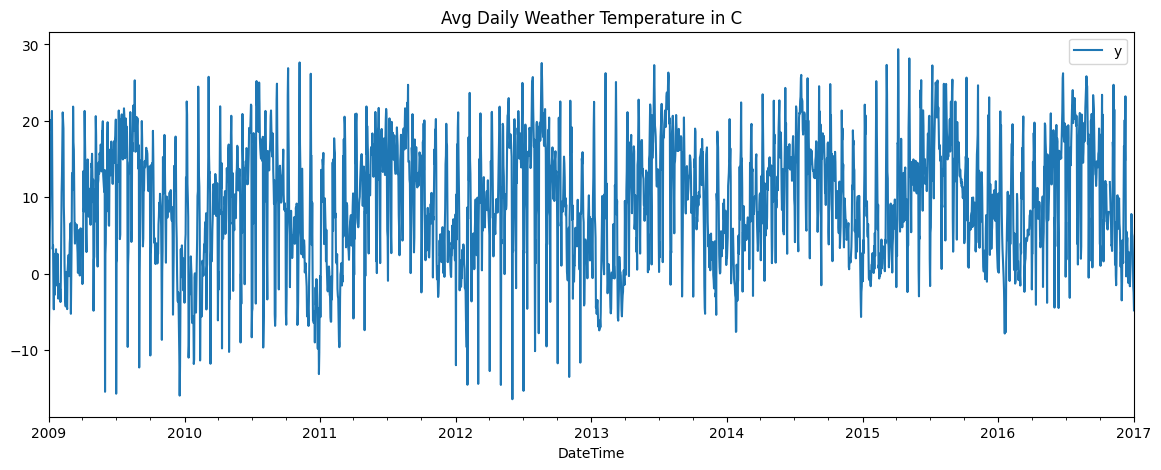

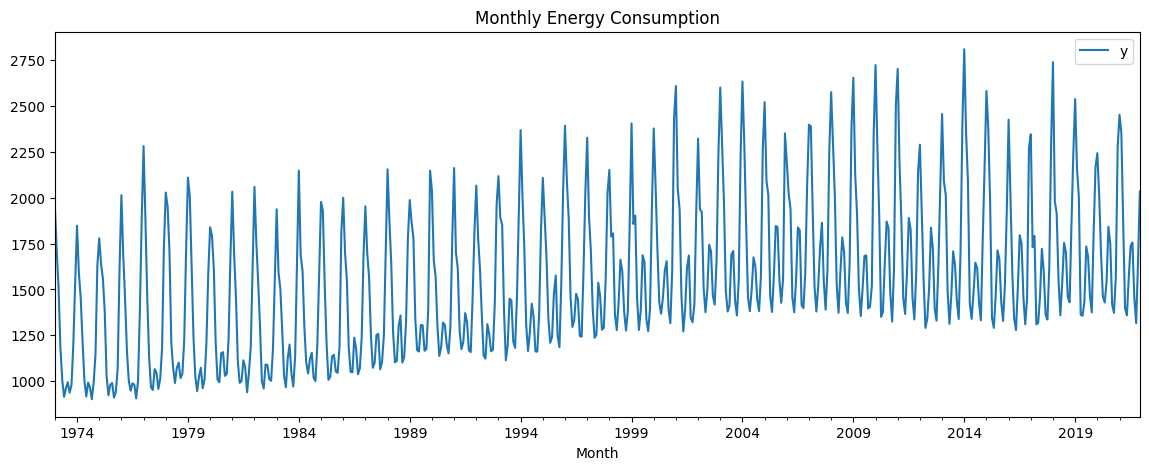

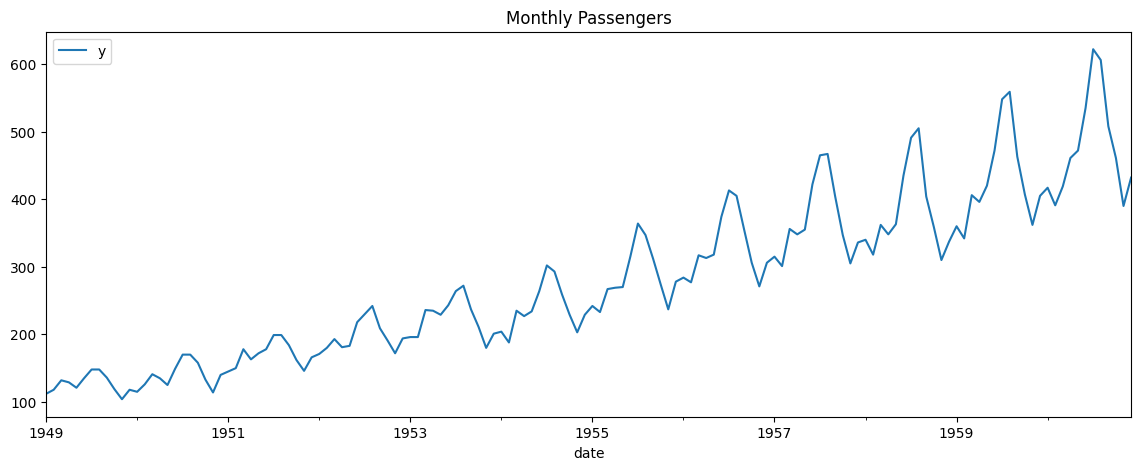

In [7]:

plt.rcParams["figure.figsize"] = [14, 5]  

daily_temp.plot(title='Avg Daily Weather Temperature in C')
energy.plot(    title='Monthly Energy Consumption')
air.plot(       title='Monthly Passengers')


In [8]:


daily_temp.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2923 entries, 2009-01-01 to 2017-01-01
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       2921 non-null   float64
dtypes: float64(1)
memory usage: 45.7 KB


In [9]:

energy.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 588 entries, 1973-01-01 to 2021-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       588 non-null    float64
dtypes: float64(1)
memory usage: 9.2 KB


In [10]:

air.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-31 to 1960-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


In [11]:

air_copy        = air.copy()
energy_copy     = energy.copy()
daily_temp_copy = daily_temp.copy()


In [12]:

def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)


In [13]:

for df in [air_copy, energy_copy, daily_temp_copy]:
    handle_missing_data(df)


found 2 missing observations...



## One step forecast with time window approach

* uses time window


In [14]:

def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()


In [15]:

air_os        = one_step_forecast(air_copy,        5)
energy_os     = one_step_forecast(energy_copy,     5)
daily_temp_os = one_step_forecast(daily_temp_copy, 5)

print(       air_os.shape)
print(    energy_os.shape)
print(daily_temp_os.shape)


(139, 6)
(583, 6)
(2918, 6)


In [16]:

air_os 


x_1  x_2  x_3  x_4  x_5    y
date                                    
1949-01-31  112  118  132  129  121  135
1949-02-28  118  132  129  121  135  148
1949-03-31  132  129  121  135  148  148
1949-04-30  129  121  135  148  148  136
1949-05-31  121  135  148  148  136  119
...         ...  ...  ...  ...  ...  ...
1960-03-31  419  461  472  535  622  606
1960-04-30  461  472  535  622  606  508
1960-05-31  472  535  622  606  508  461
1960-06-30  535  622  606  508  461  390
1960-07-31  622  606  508  461  390  432

[139 rows x 6 columns]

In [17]:

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test


In [18]:

train, test = split_data(air_os)

print(f'Train: {len(train)} Test: {len(test)}')


Train: 119 Test: 20


In [19]:

class Standardize:
    def __init__(self, split=0.15):
        self.split = split
    
    def _transform(self, df):
        return (df - self.mu)/self.sigma
    
    def split_data(self, df):
        n = int(len(df) * test_split)
        train, test = df[:-n], df[-n:]
        return train, test
    
    def fit_transform(self, train, test):
        self.mu = train.mean()
        self.sigma = train.std()
        train_s = self._transform(train)
        test_s =  self._transform(test)
        return train_s, test_s

    def transform(self, df):
        return self._transform(df)
    
    def inverse(self, df):
        return (df * self.sigma)+self.mu
        
    def inverse_y(self, df):
        return (df * self.sigma[0])+self.mu[0]


In [20]:

scaler = Standardize()

train_s, test_s = scaler.fit_transform(train, test)

train_s.head()


x_1       x_2       x_3       x_4       x_5         y
date                                                                  
1949-01-31 -1.401933 -1.364908 -1.240908 -1.294771 -1.398791 -1.273682
1949-02-28 -1.338755 -1.216817 -1.272708 -1.379791 -1.250613 -1.136238
1949-03-31 -1.191342 -1.248551 -1.357508 -1.231006 -1.113020 -1.136238
1949-04-30 -1.222930 -1.333174 -1.209108 -1.092848 -1.113020 -1.263109
1949-05-31 -1.307167 -1.185083 -1.071309 -1.092848 -1.240029 -1.442843

In [21]:

y_train_original = scaler.inverse_y(train_s['y'])


In [22]:

train_original = scaler.inverse(train_s)
train_original.head()


x_1    x_2    x_3    x_4    x_5      y
date                                                
1949-01-31  112.0  118.0  132.0  129.0  121.0  135.0
1949-02-28  118.0  132.0  129.0  121.0  135.0  148.0
1949-03-31  132.0  129.0  121.0  135.0  148.0  148.0
1949-04-30  129.0  121.0  135.0  148.0  148.0  136.0
1949-05-31  121.0  135.0  148.0  148.0  136.0  119.0

In [23]:

air_cp = air.copy()
en_cp = energy.copy()
dw_cp = daily_temp.copy()


In [24]:

for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)


found 2 missing observations...


In [25]:

air_reg = one_step_forecast(air_cp, 10)
en_reg = one_step_forecast(en_cp, 10)
dw_reg = one_step_forecast(dw_cp, 10)


In [26]:

print(air_reg.shape)
print(en_reg.shape)
print(dw_reg.shape)


(134, 11)
(578, 11)
(2913, 11)


In [27]:

mse  = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()


In [28]:

train_air, test_air = split_data(air_reg, test_split=0.10)
scaler_air = Standardize()
train_air_s, test_air_s = scaler_air.fit_transform(train_air,test_air)


In [29]:

train_en, test_en = split_data(en_reg, test_split=0.10)
scaler_en = Standardize()
train_en_s, test_en_s = scaler_en.fit_transform(train_en, test_en)


In [30]:

train_dw, test_dw = split_data(dw_reg, test_split=0.10)
scaler_dw = Standardize()
train_dw_s, test_dw_s = scaler_dw.fit_transform(train_dw,test_dw)


In [31]:

regressors = {
    'Linear Regression': LinearRegression(fit_intercept=False),
    'Elastic Net': ElasticNet(0.5, fit_intercept=False),
    'Ridge Regression': Ridge(0.5, fit_intercept=False),
    'Lasso Regression': Lasso(0.5, fit_intercept=False),
    'Huber Regression': HuberRegressor(fit_intercept=False)}


In [32]:

def train_model(train, test, regressor, reg_name):
    X_train, y_train  = train.drop(columns=['y']), train['y']
    X_test, y_test  = test.drop(columns=['y']), test['y']   

    print(f'training {reg_name} ...')
    
    regressor.fit(X_train, y_train) 
     
    yhat = regressor.predict(X_test)    
    rmse_test = np.sqrt(mse(y_test, yhat))
    mape_test = mape(y_test, yhat)
    mase_test = mase(y_test, yhat, y_train=y_train)    
    residuals = y_test.values - yhat     
    
    model_metadata = {
        'Model Name': reg_name, 'Model': regressor, 
        'RMSE': rmse_test, 'MAPE': mape_test, 'MASE': mase_test,
        'yhat': yhat, 'resid': residuals, 'actual': y_test.values}

    return model_metadata


In [33]:

def train_different_models(train, test, regressors):
    results = []
    for reg_name, regressor in regressors.items():
        results.append(train_model(train,
                                   test,
                                   regressor,
                                   reg_name))
    return results


In [34]:

air_results = train_different_models(train_air_s, test_air_s, regressors)
en_results = train_different_models(train_en_s, test_en_s, regressors)
dw_results = train_different_models(train_dw_s, test_dw_s, regressors)


training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...
training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [35]:


def plot_results(cols, results, data_name):
    for row in results[cols].iterrows():
        yhat, resid, actual, name = row[1]
        plt.title(f'{data_name} - {name}')
        plt.plot(actual, 'k--', alpha=0.5)
        plt.plot(yhat, 'k')
        plt.legend(['actual', 'forecast'])
        plot_acf(resid, zero=False, 
                 title=f'{data_name} - Autocorrelation')
        plt.show()


In [36]:

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
air_results = pd.DataFrame(air_results)
air_results[cols].sort_values('MASE')


Model Name      RMSE      MAPE      MASE
2   Ridge Regression  0.381092  0.202191  1.390807
0  Linear Regression  0.385559  0.205371  1.411072
4   Huber Regression  0.400949  0.214912  1.457932
1        Elastic Net  0.829023  0.328472  2.808737
3   Lasso Regression  1.190006  0.551243  4.439302

In [37]:

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_results = pd.DataFrame(en_results)
en_results[cols].sort_values('MASE')


Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.431651  1.419527  0.525526
2   Ridge Regression  0.433192  1.586383  0.560450
0  Linear Regression  0.433747  1.583406  0.560989
1        Elastic Net  0.747657  1.822362  1.013425
3   Lasso Regression  0.834356  1.548537  1.108092

In [38]:

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
dw_results = pd.DataFrame(dw_results)
dw_results[cols].sort_values('MASE')


Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.655729  1.083826  0.968735
0  Linear Regression  0.646648  1.037424  0.990057
2   Ridge Regression  0.646639  1.037273  0.990085
1        Elastic Net  0.737896  0.913599  1.300792
3   Lasso Regression  0.814609  0.911730  1.468567

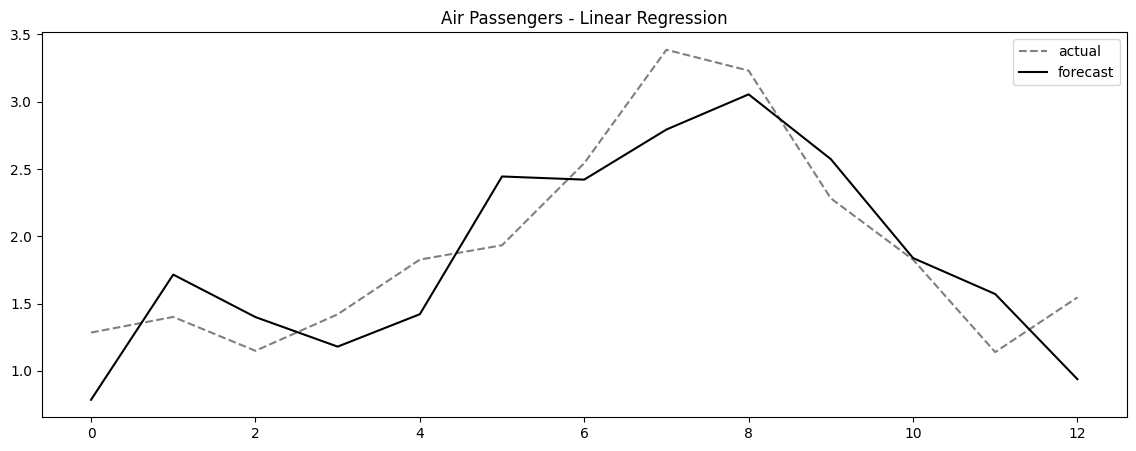

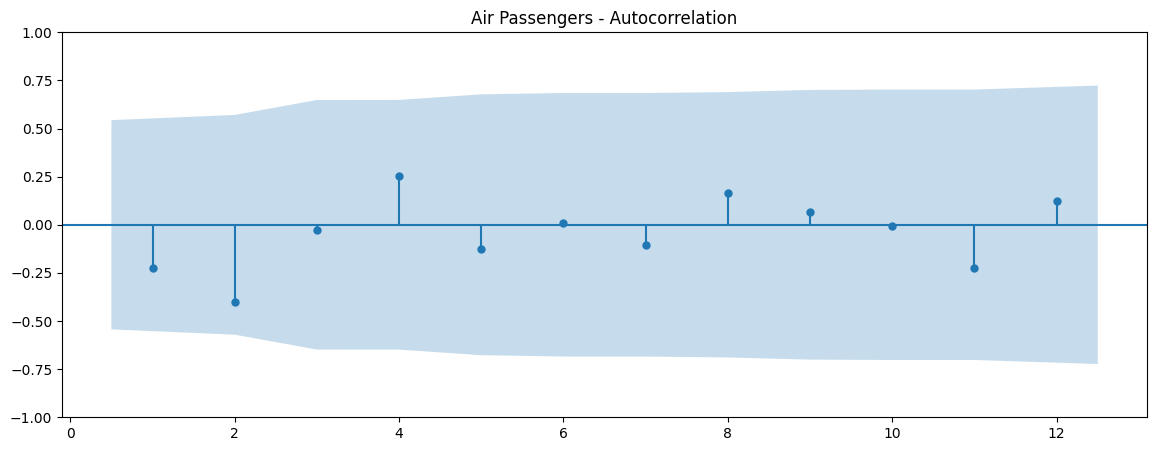

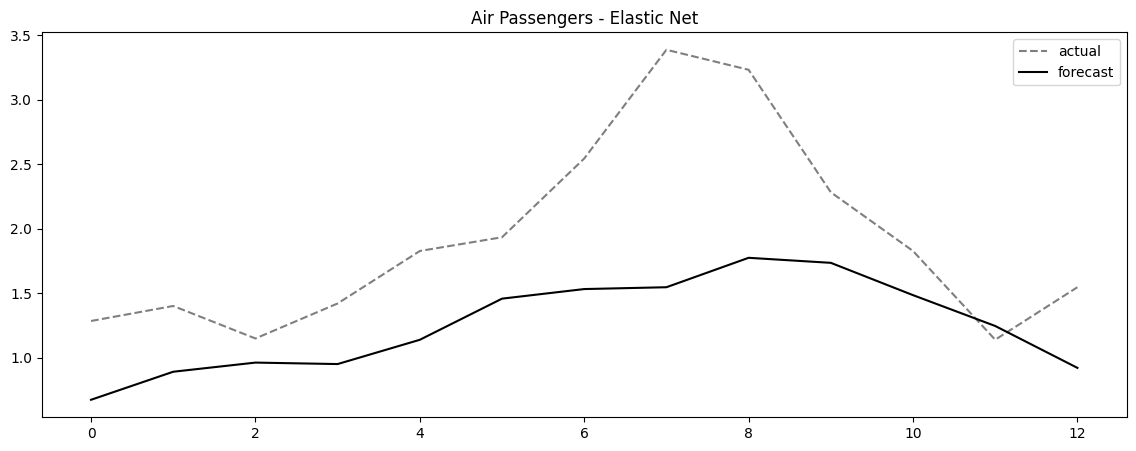

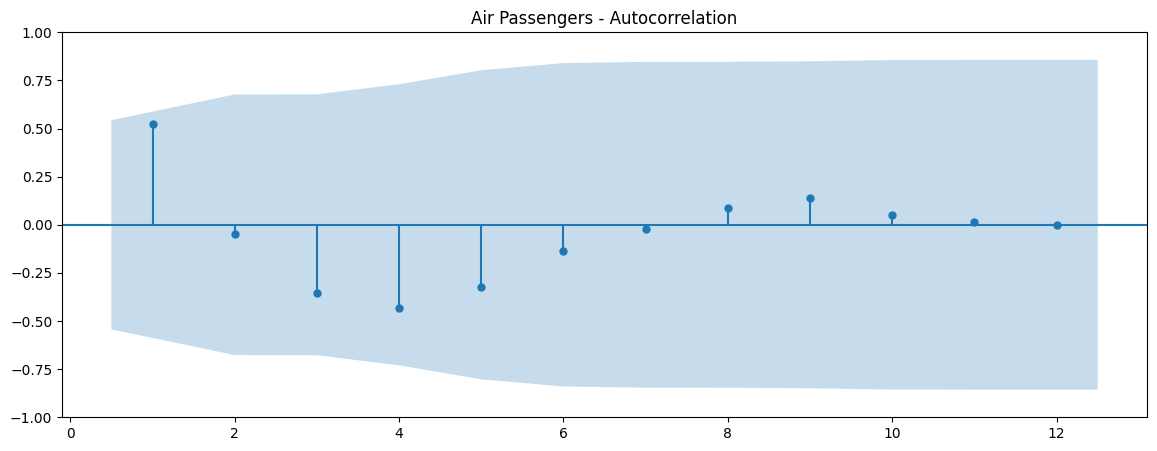

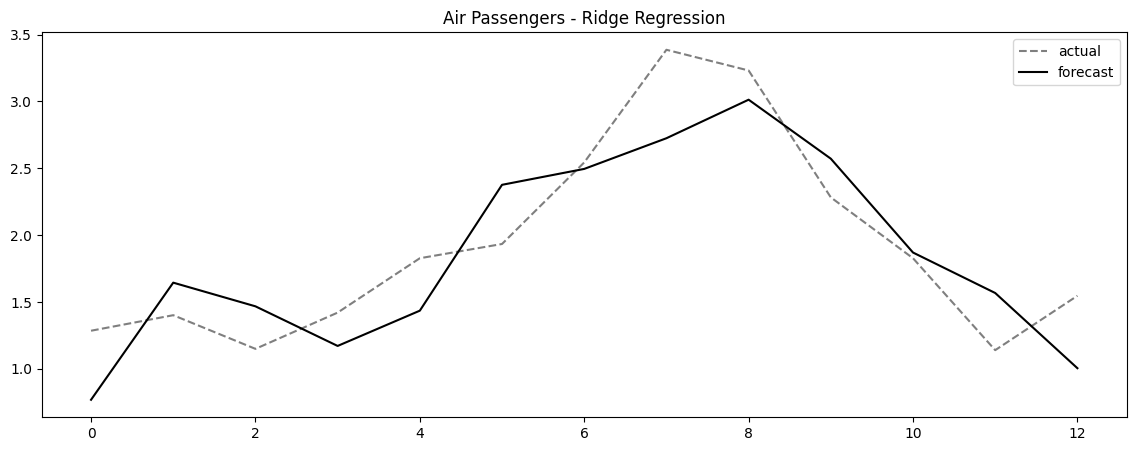

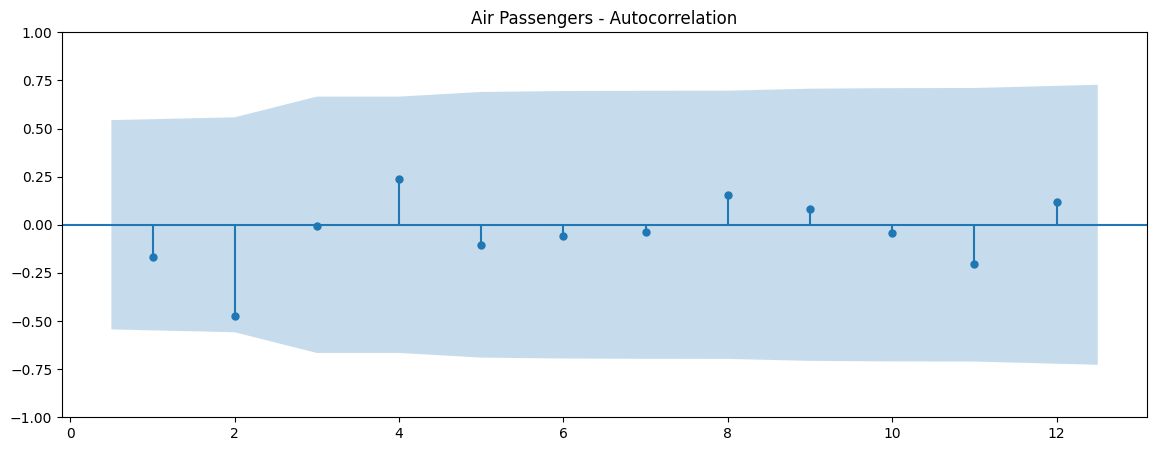

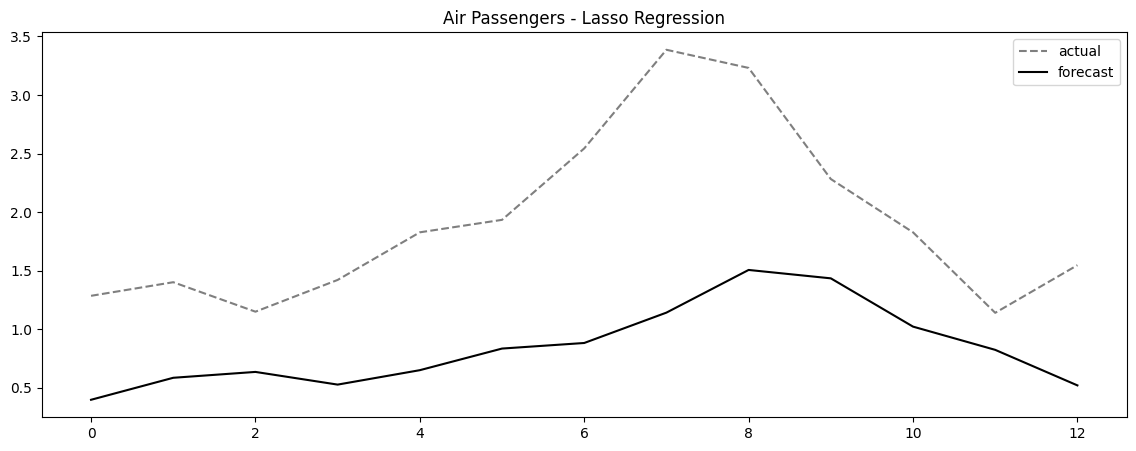

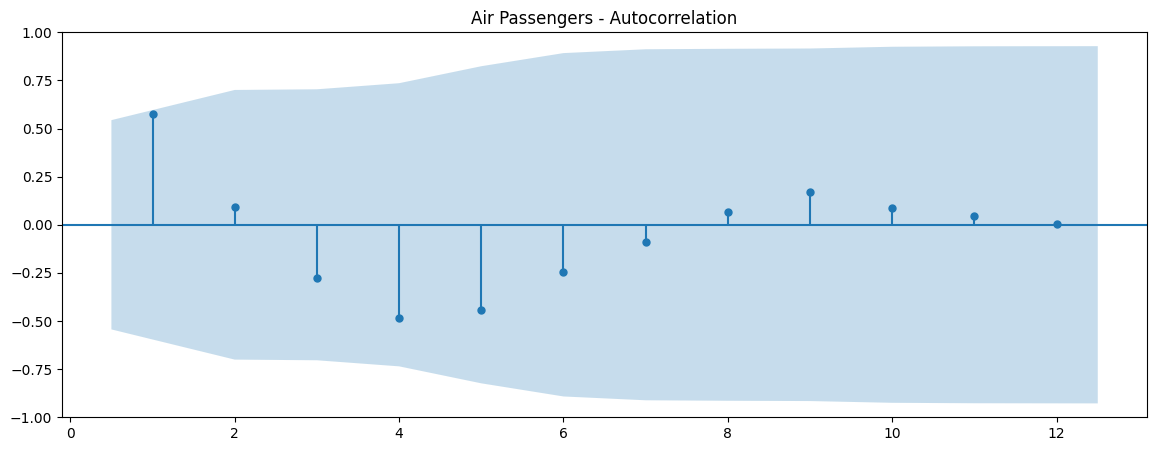

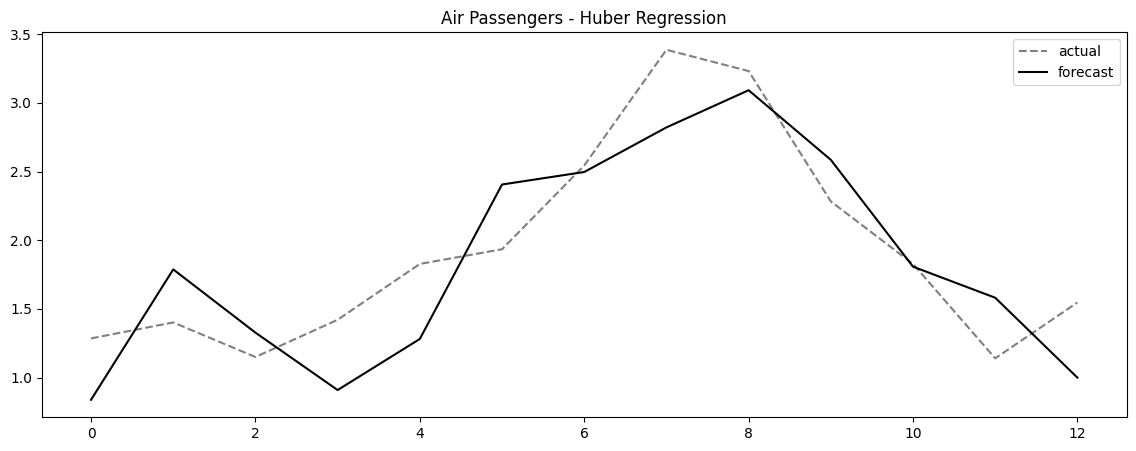

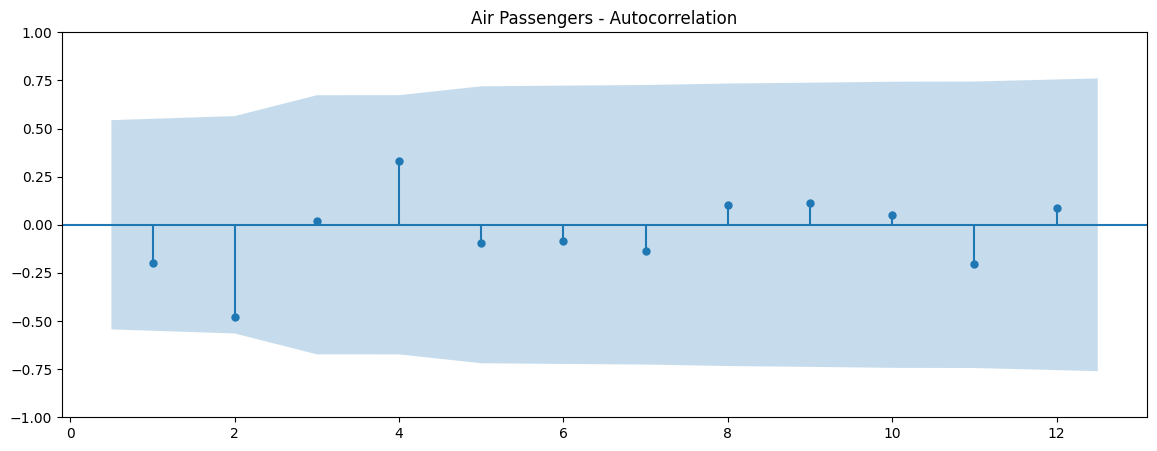

In [39]:

cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, air_results, 'Air Passengers')


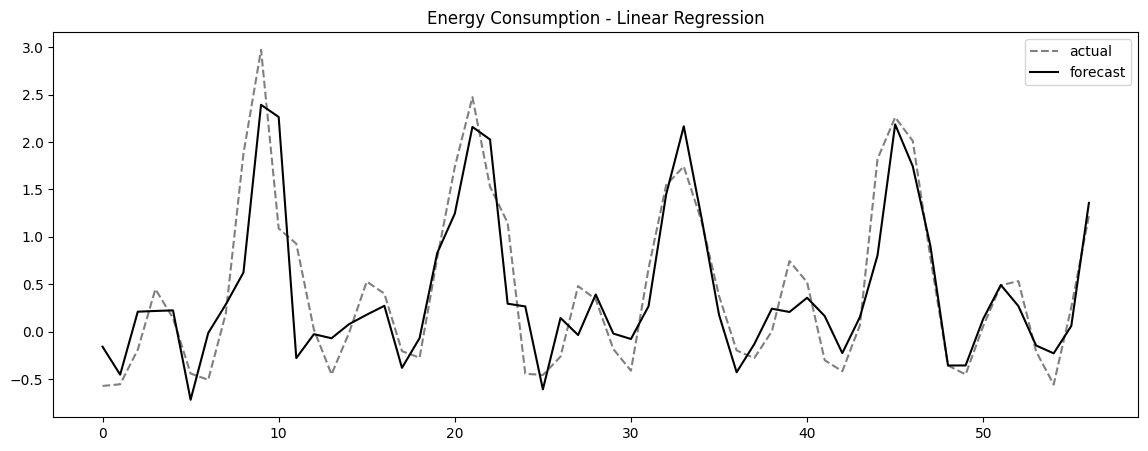

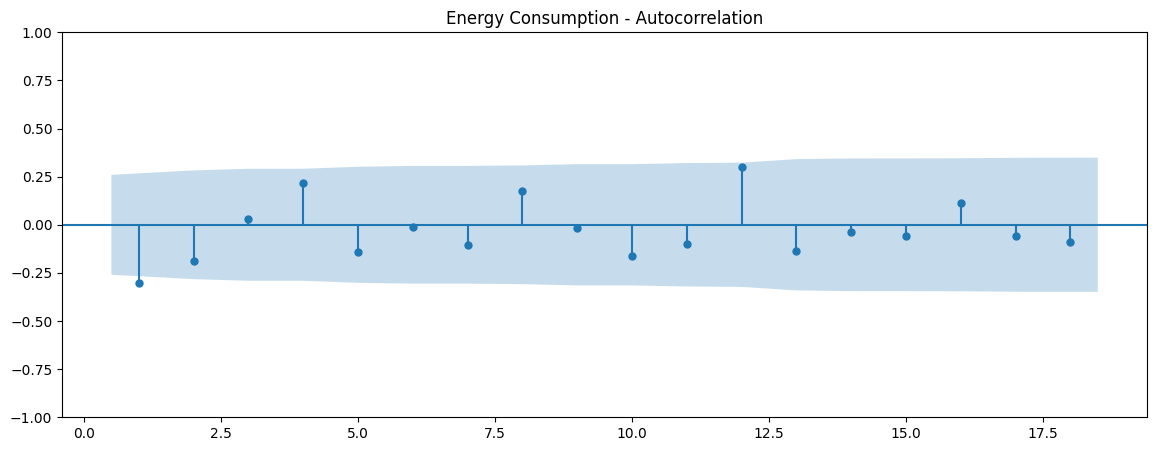

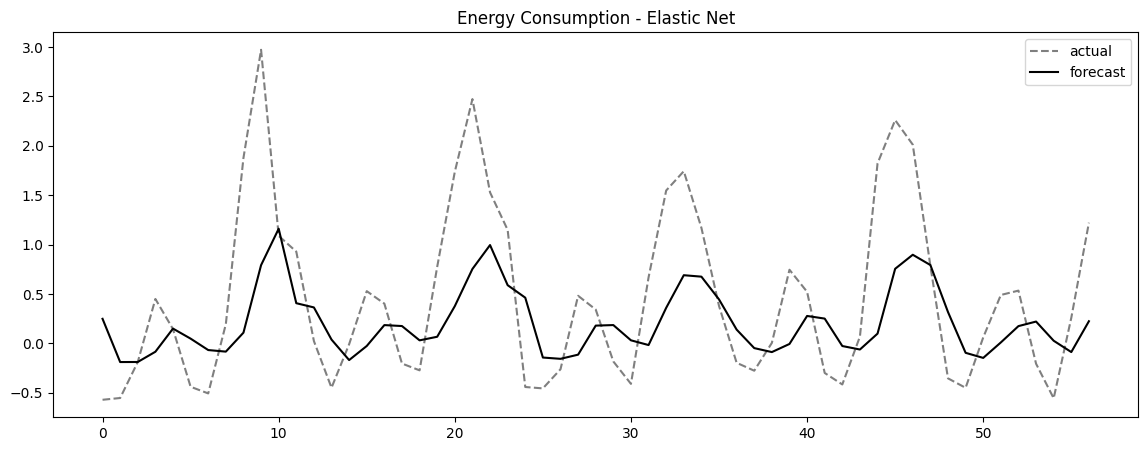

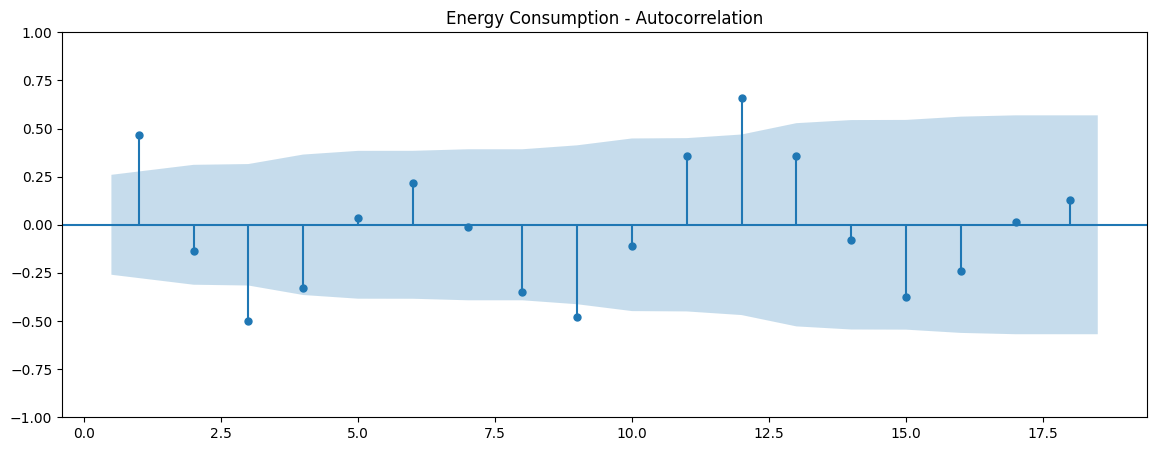

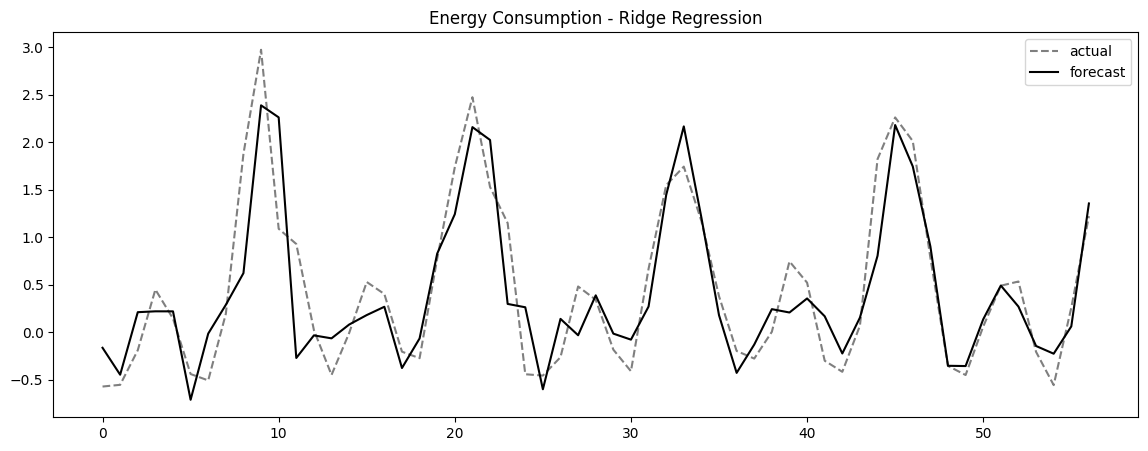

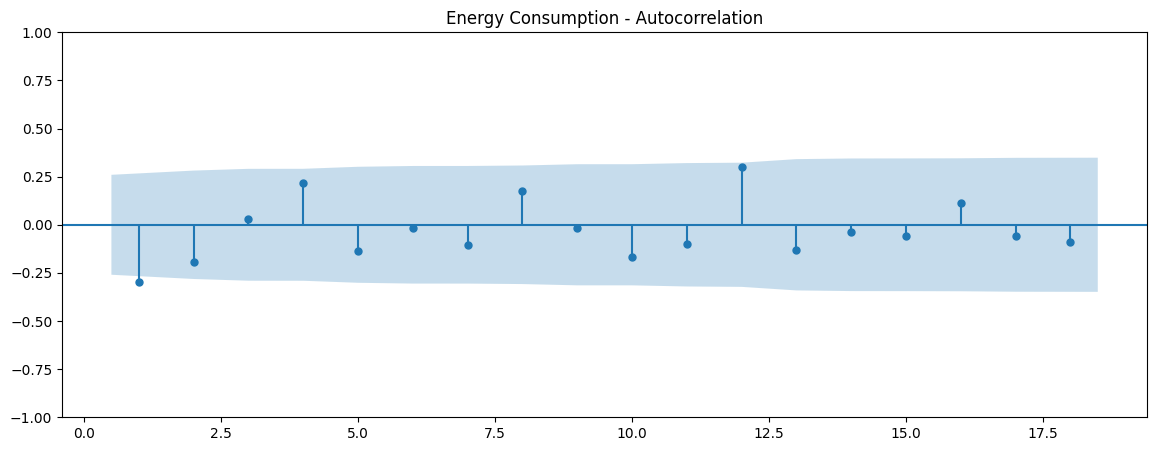

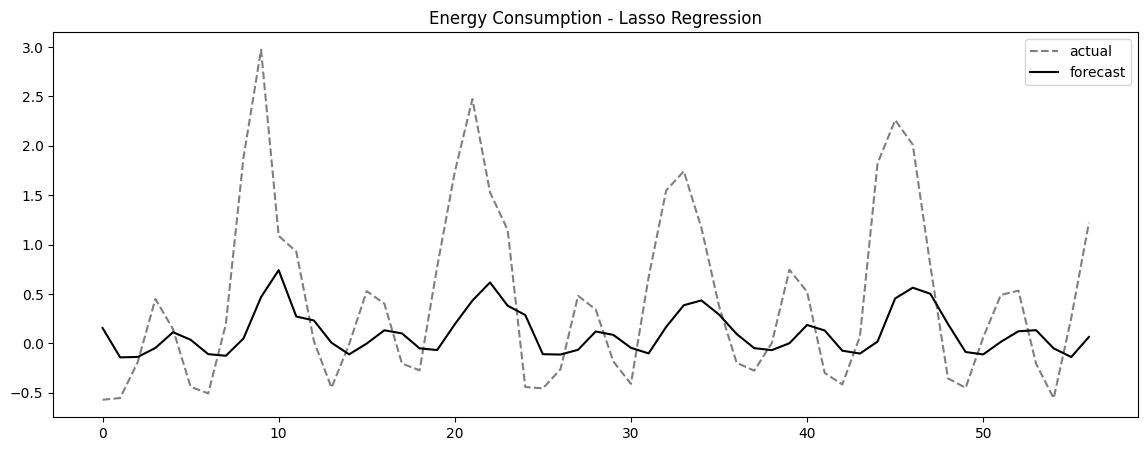

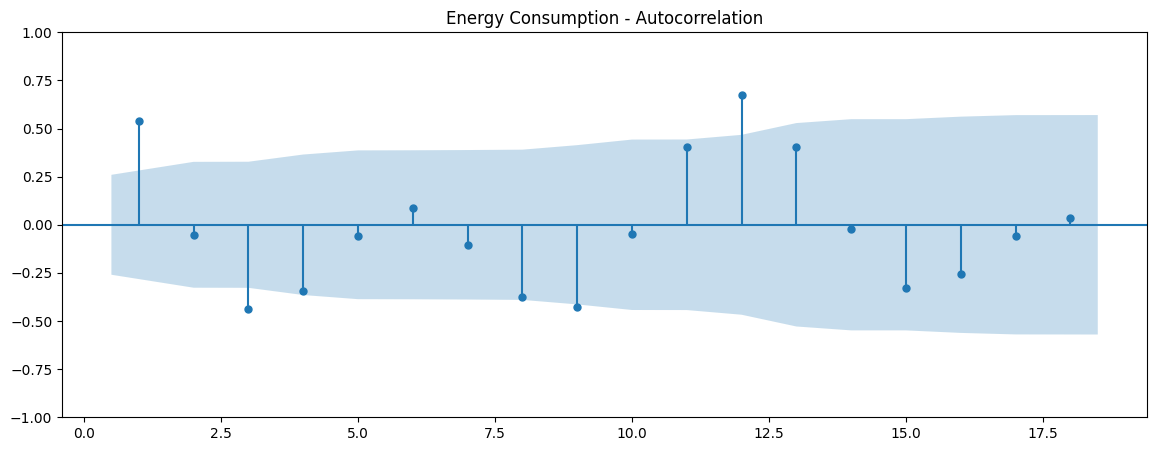

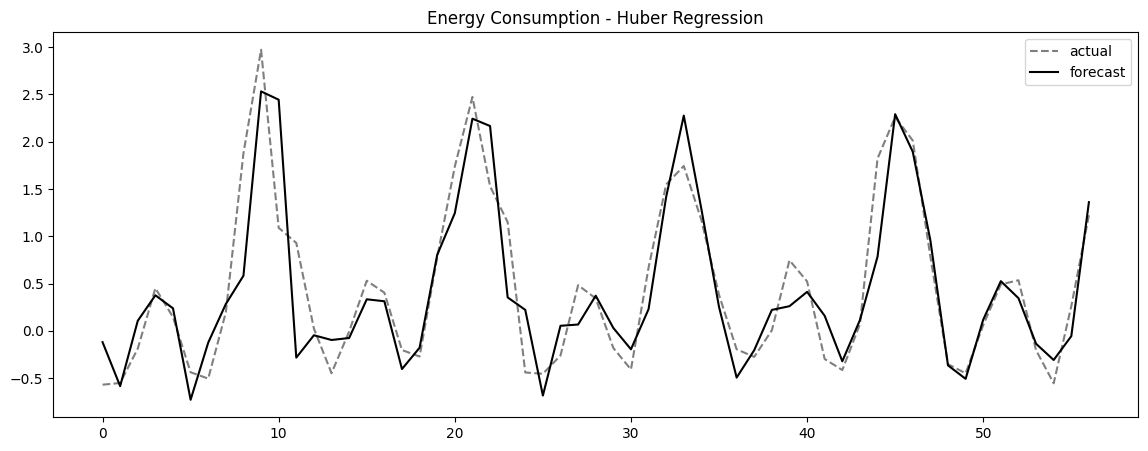

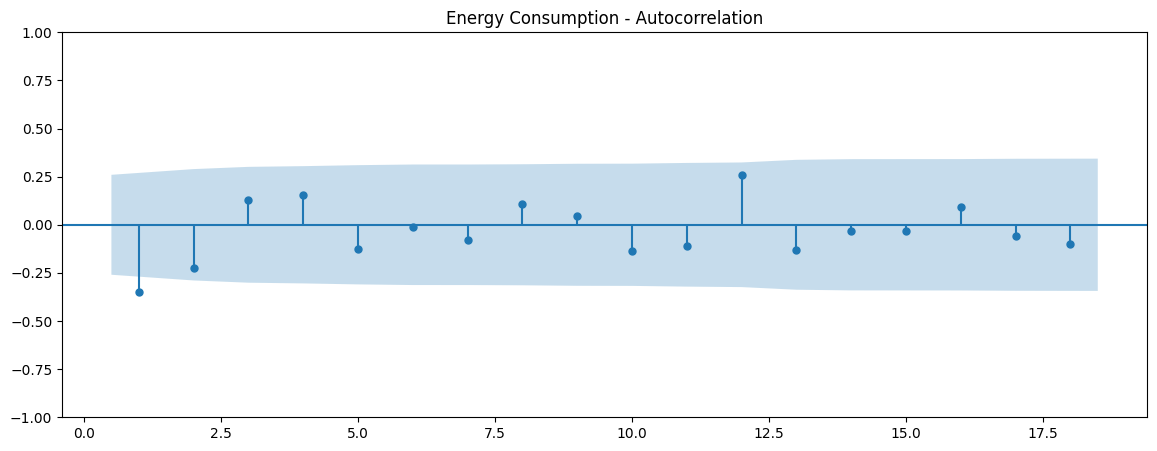

In [40]:

plot_results(cols, en_results, 'Energy Consumption')


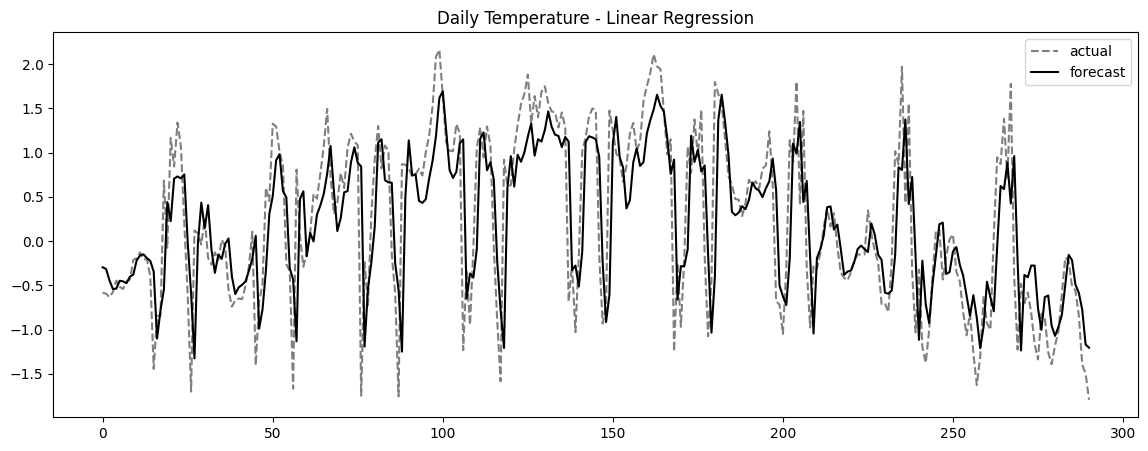

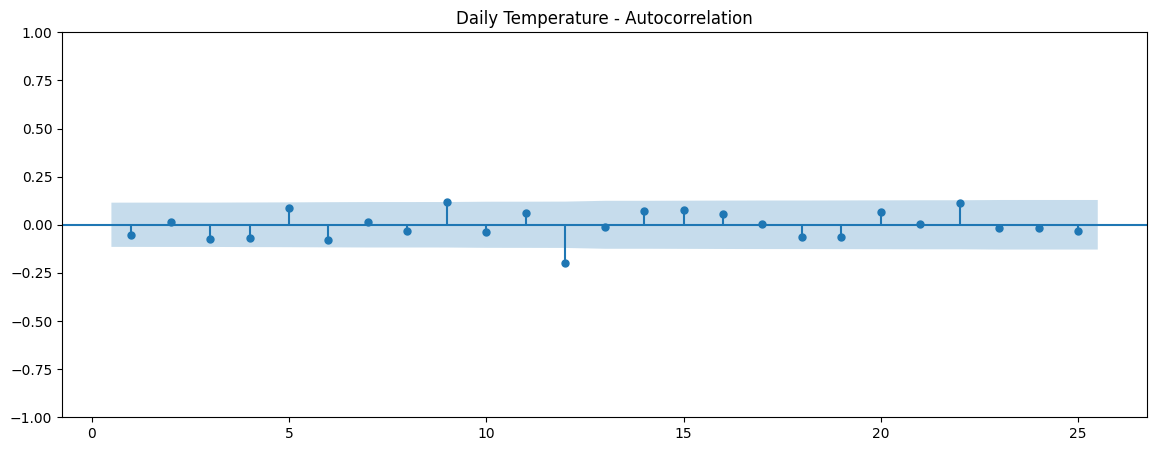

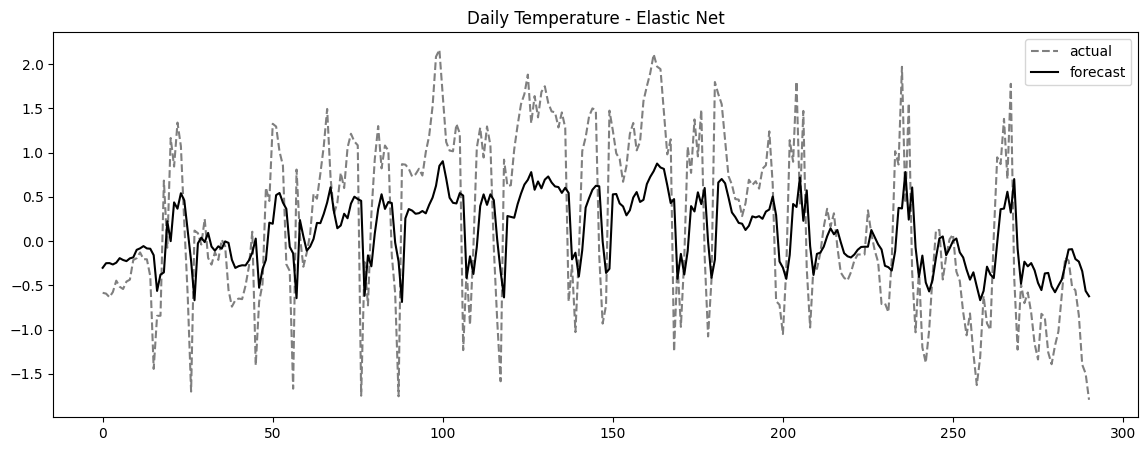

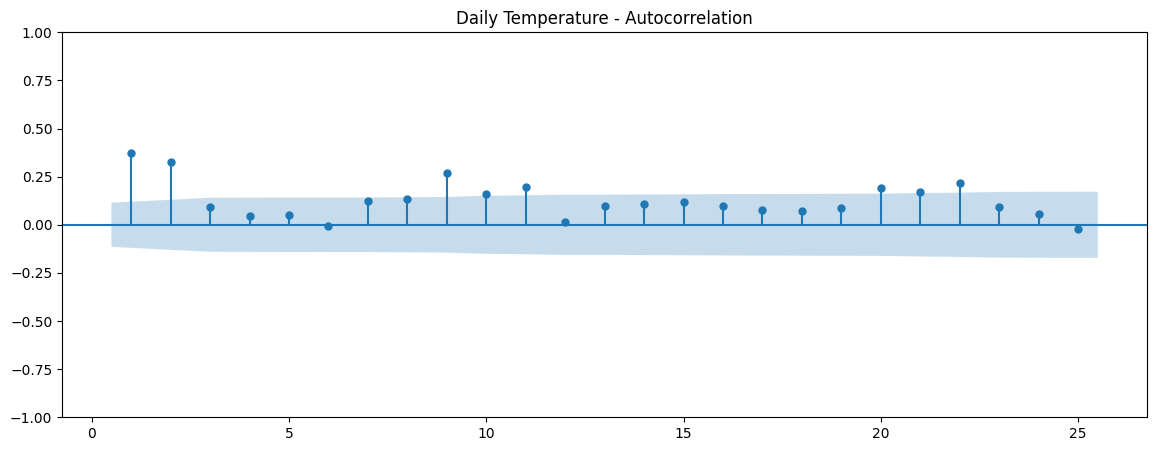

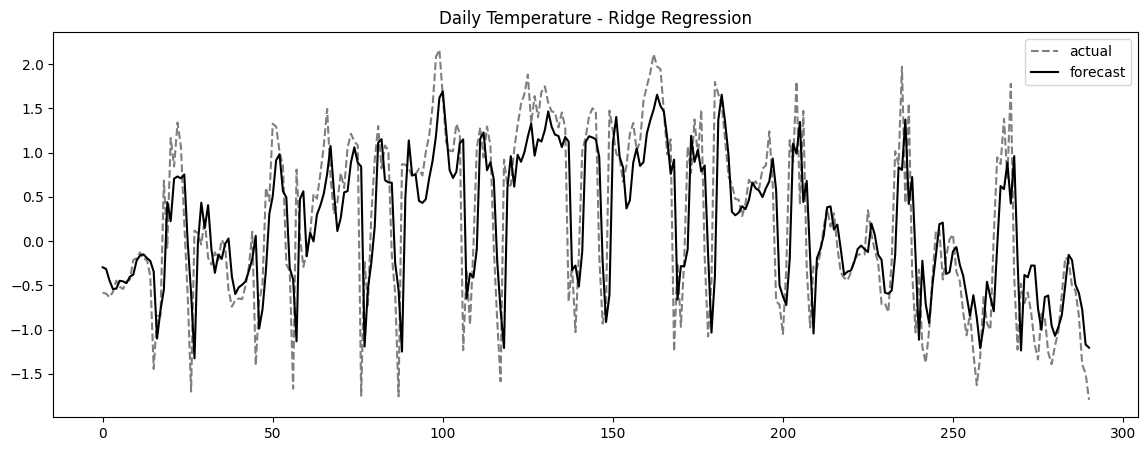

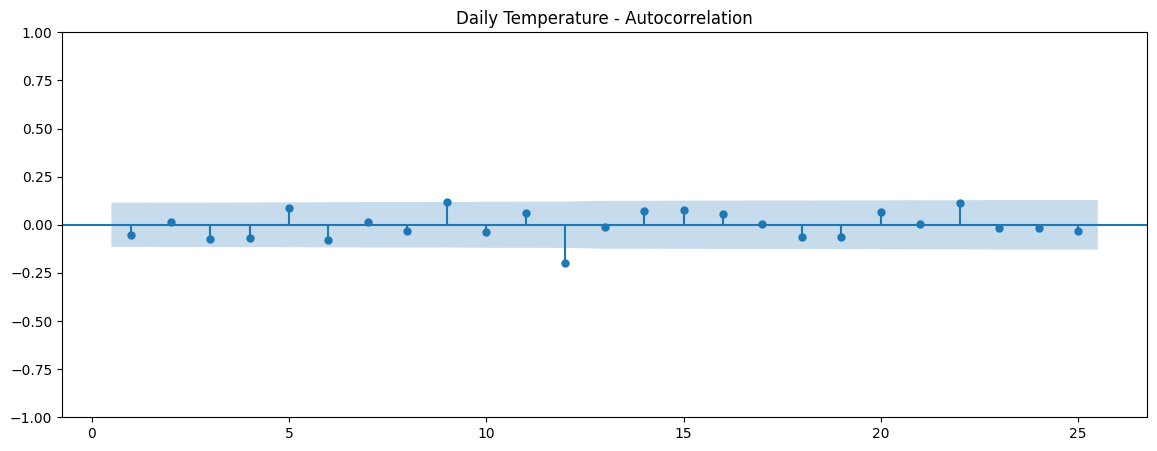

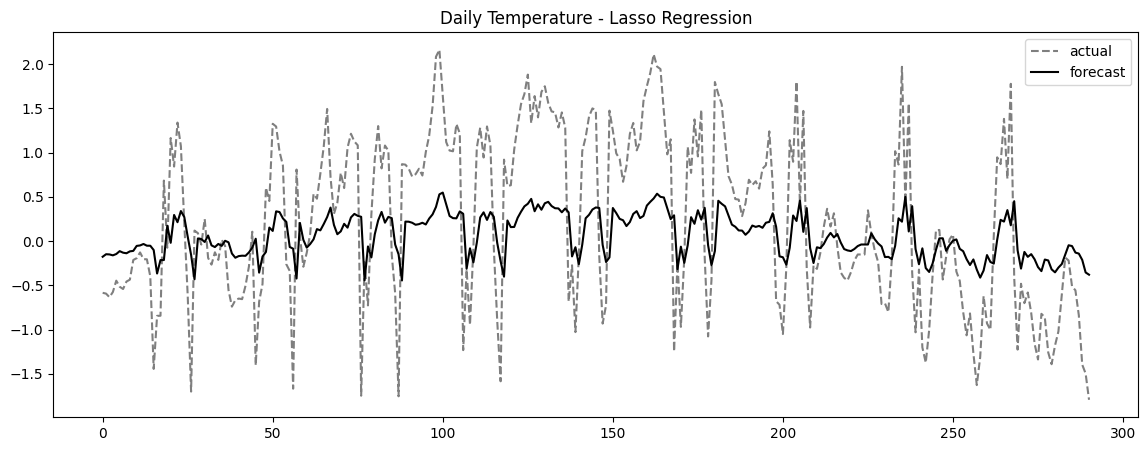

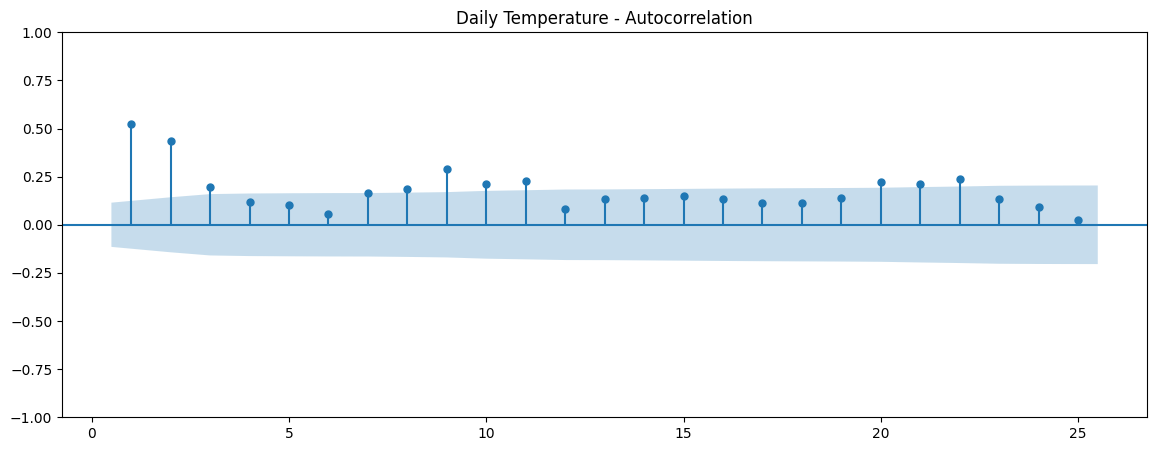

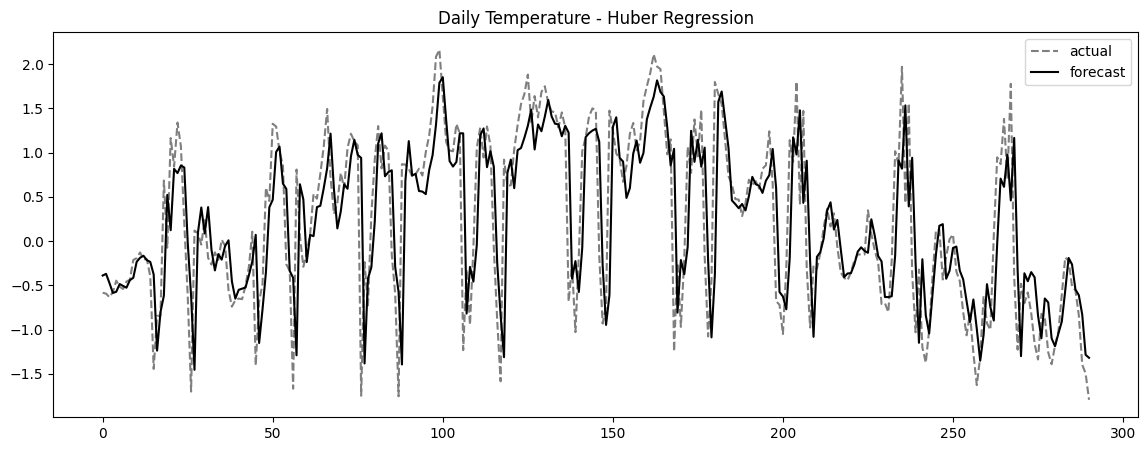

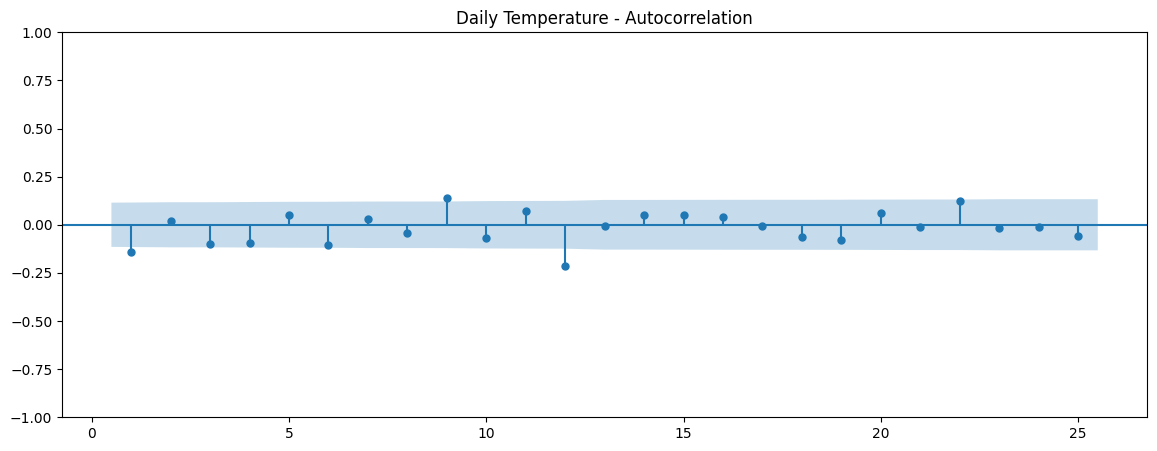

In [41]:

plot_results(cols, dw_results, 'Daily Temperature')


In [42]:

cols = ['Model Name', 'Model']
en_models = en_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)


Linear Regression
[ 0.02739136  0.02052173  0.03768302  0.06630472  0.01417452 -0.08727704
  0.02856578 -0.13640839  0.14165493  0.70683461]
Elastic Net
[0.         0.         0.         0.         0.         0.
 0.         0.         0.04077799 0.37835549]
Ridge Regression
[ 0.0273999   0.02054709  0.0377177   0.06625515  0.01414968 -0.08721396
  0.02844889 -0.13622568  0.14175768  0.7065417 ]
Lasso Regression
[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.2536153]


In [43]:

en_10 = en_reg[['y', 'x_10']]

train_en10, test_en10 = split_data(en_10, test_split=0.10)
scaler_en10 = Standardize()
train_en10_s, test_en10_s = scaler_en.fit_transform(train_en10, test_en10)

en_10_results = train_different_models(train_en10_s, test_en10_s, regressors)

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
en_10_results = pd.DataFrame(en_results)
en_10_results[cols].sort_values('MASE')


training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


Model Name      RMSE      MAPE      MASE
4   Huber Regression  0.431651  1.419527  0.525526
2   Ridge Regression  0.433192  1.586383  0.560450
0  Linear Regression  0.433747  1.583406  0.560989
1        Elastic Net  0.747657  1.822362  1.013425
3   Lasso Regression  0.834356  1.548537  1.108092

In [44]:

en_reg


x_1       x_2       x_3       x_4       x_5       x_6  \
Month                                                                    
1973-01-01  1957.641  1712.143  1510.079  1183.421  1006.326   914.949   
1973-02-01  1712.143  1510.079  1183.421  1006.326   914.949   961.872   
1973-03-01  1510.079  1183.421  1006.326   914.949   961.872   994.259   
1973-04-01  1183.421  1006.326   914.949   961.872   994.259   937.083   
1973-05-01  1006.326   914.949   961.872   994.259   937.083   978.162   
...              ...       ...       ...       ...       ...       ...   
2020-10-01  1372.201  1567.707  2274.277  2451.101  2350.977  1856.031   
2020-11-01  1567.707  2274.277  2451.101  2350.977  1856.031  1397.144   
2020-12-01  2274.277  2451.101  2350.977  1856.031  1397.144  1358.566   
2021-01-01  2451.101  2350.977  1856.031  1397.144  1358.566  1564.205   
2021-02-01  2350.977  1856.031  1397.144  1358.566  1564.205  1737.442   

                 x_7       x_8       x_9      x_10         y  
Month                                                         
1973-01-01   961.872   994.259   937.083   978.162  1202.105  
1973-02-01   994.259   937.083   978.162  1202.105  1538.568  
1973-03-01   937.083   978.162  1202.105  1538.568  1846.930  
1973-04-01   978.162  1202.105  1538.568  1846.930  1589.448  
1973-05-01  1202.105  1538.568  1846.930  1589.448  1451.073  
...              ...       ...       ...       ...       ...  
2020-10-01  1397.144  1358.566  1564.205  1737.442  1755.212  
2020-11-01  1358.566  1564.205  1737.442  1755.212  1456.901  
2020-12-01  1564.205  1737.442  1755.212  1456.901  1315.799  
2021-01-01  1737.442  1755.212  1456.901  1315.799  1644.306  
2021-02-01  1755.212  1456.901  1315.799  1644.306  2032.352  

[578 rows x 11 columns]

In [45]:

en_10


y      x_10
Month                         
1973-01-01  1202.105   978.162
1973-02-01  1538.568  1202.105
1973-03-01  1846.930  1538.568
1973-04-01  1589.448  1846.930
1973-05-01  1451.073  1589.448
...              ...       ...
2020-10-01  1755.212  1737.442
2020-11-01  1456.901  1755.212
2020-12-01  1315.799  1456.901
2021-01-01  1644.306  1315.799
2021-02-01  2032.352  1644.306

[578 rows x 2 columns]

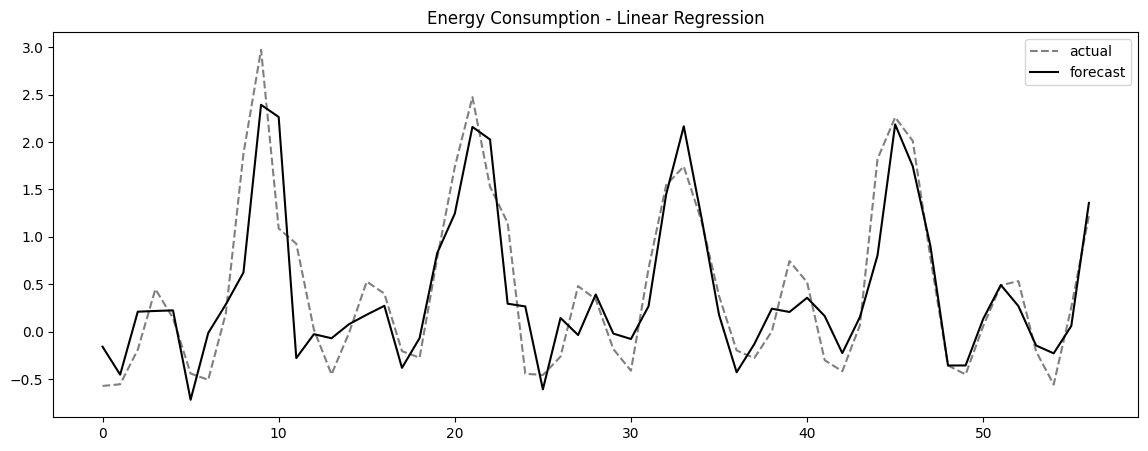

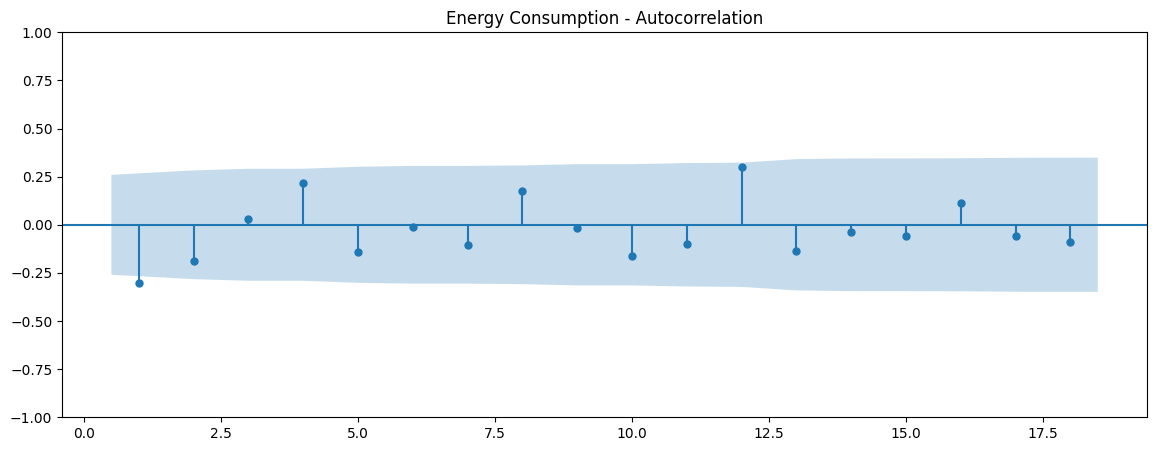

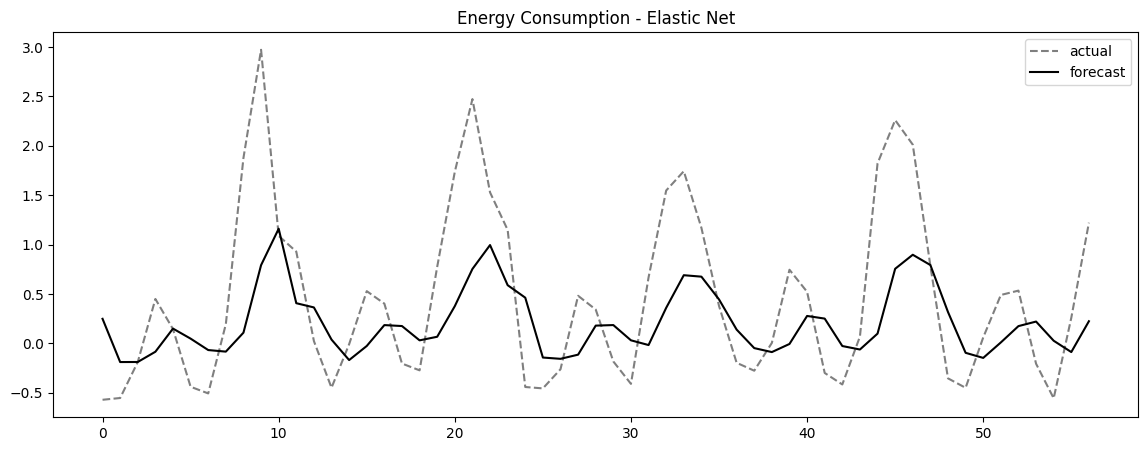

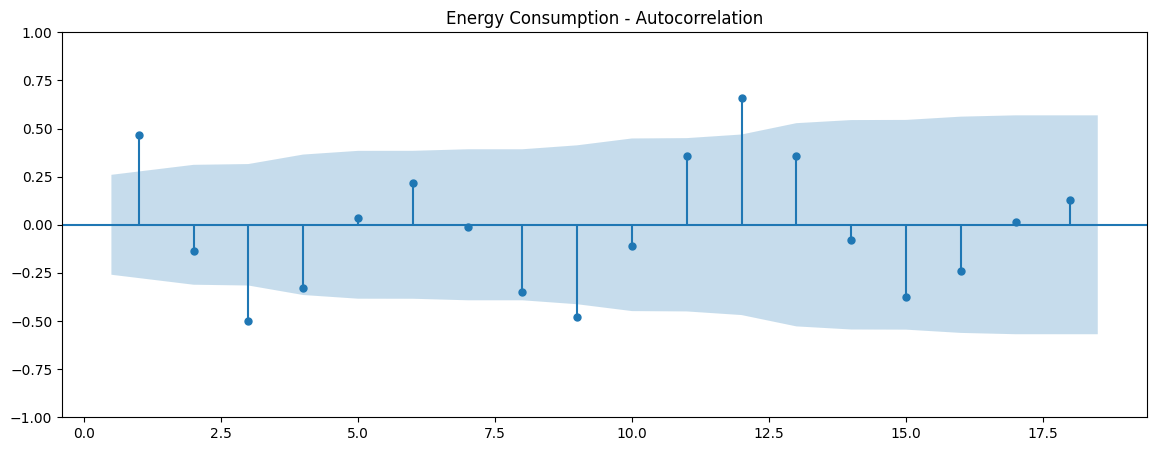

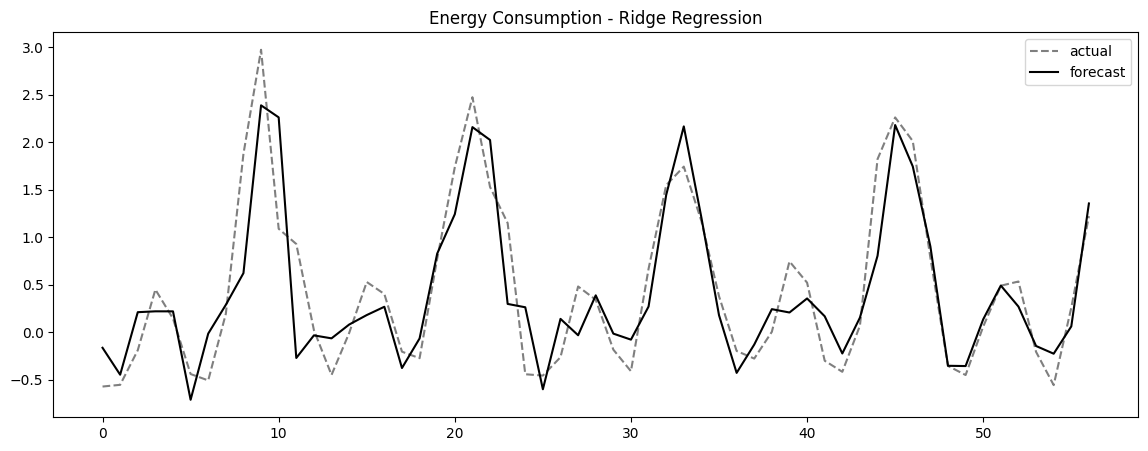

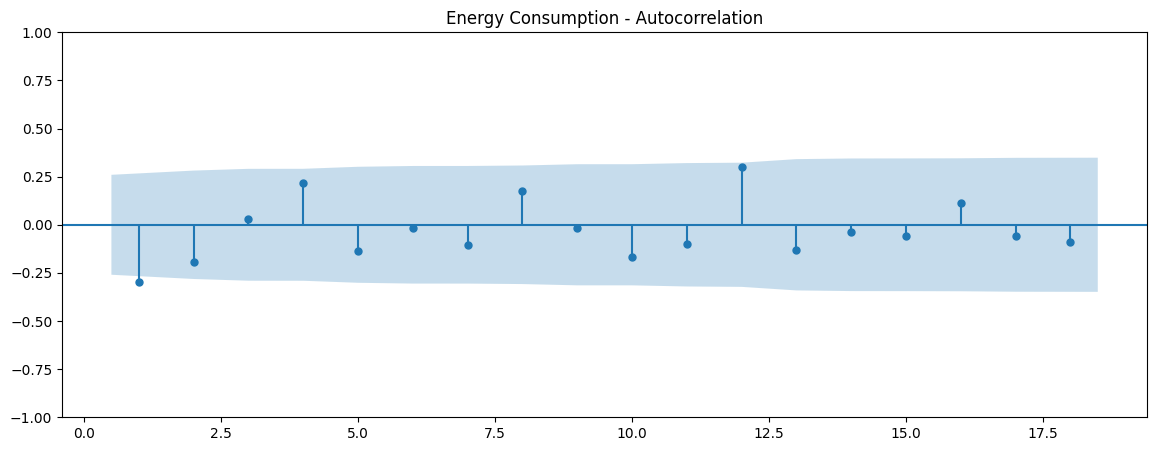

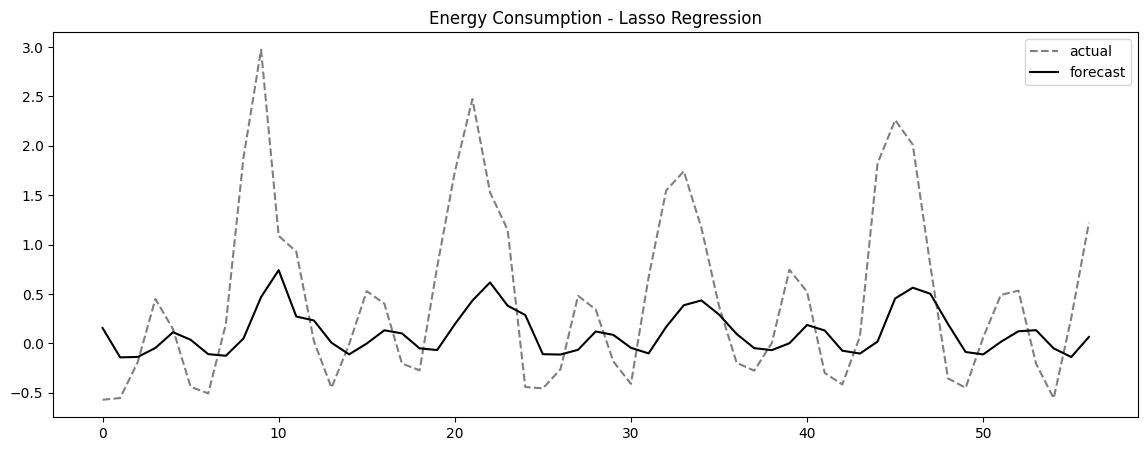

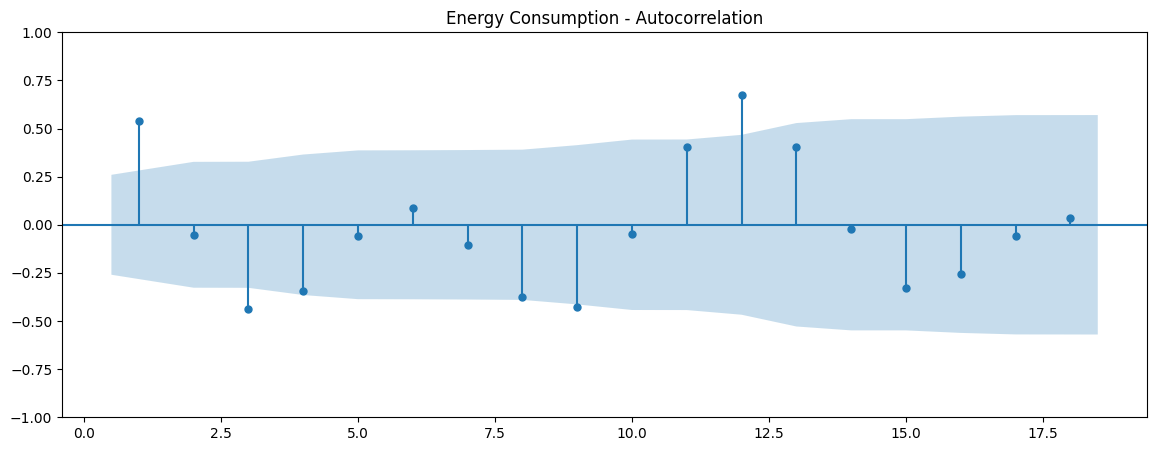

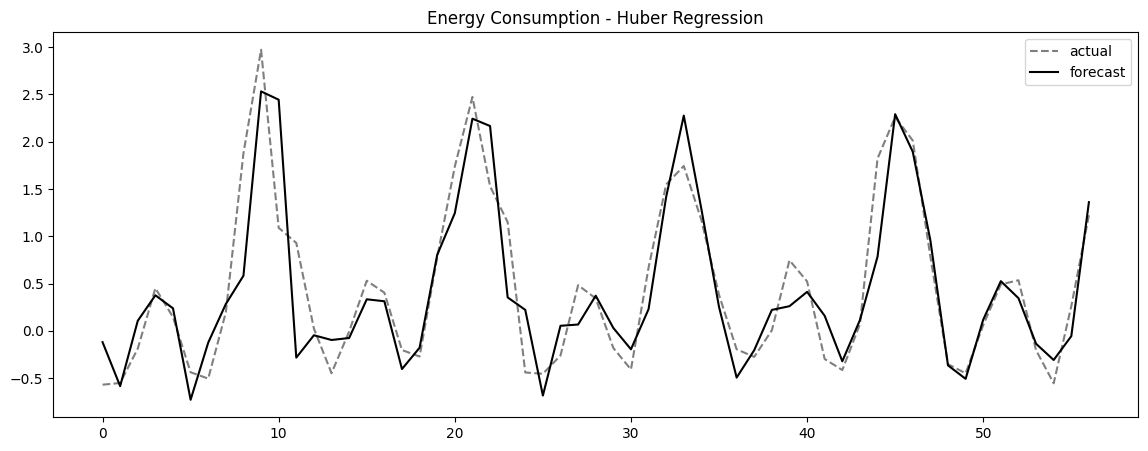

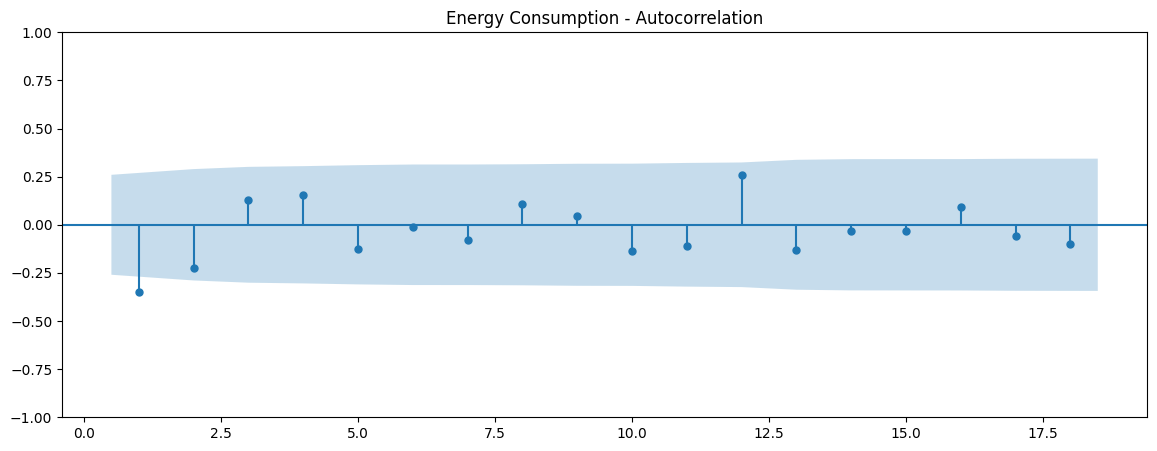

In [46]:
cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results(cols, en_10_results, 'Energy Consumption')


In [47]:

cols = ['Model Name', 'Model']
en_models = en_10_results.iloc[0:4][cols]

for row in en_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)


Linear Regression
[0.75051783]
Elastic Net
[0.39987585]
Ridge Regression
[0.74979687]
Lasso Regression
[0.24955629]



## Silicon Data


In [48]:
'''
ts_silicon_data = pd.read_csv(
            'data/RealSeqData.CIVS.Nov.2023.csv',
            header=0,
            parse_dates = ['time'],
            index_col=0,
            infer_datetime_format=True,
            usecols=['time', 'o_SILICON_14']
)
'''


"\nts_silicon_data = pd.read_csv(\n            'data/RealSeqData.CIVS.Nov.2023.csv',\n            header=0,\n            parse_dates = ['time'],\n            index_col=0,\n            infer_datetime_format=True,\n            usecols=['time', 'o_SILICON_14']\n)\n"

In [49]:

ts_silicon_data = pd.read_csv(
                          'data/RealSeqData.CIVS.Nov.2023.csv', 
                          index_col='time', 
                          parse_dates=True,
                          usecols=['time', 'o_SILICON_14']
)

## ts_silicon_data.columns = ['y']


In [50]:

## makes sure values are in order 

ts_silicon_data.sort_index(inplace = True)


In [51]:

ts_silicon_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265020 entries, 2021-08-01 00:00:00 to 2022-01-31 23:59:00
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   o_SILICON_14  265020 non-null  float64
dtypes: float64(1)
memory usage: 4.0 MB


In [52]:

## ts_silicon_data.index.freq = 'D'


In [53]:

print(ts_silicon_data.index.freq)


None


<Axes: title={'center': 'Silicon data'}, xlabel='time'>

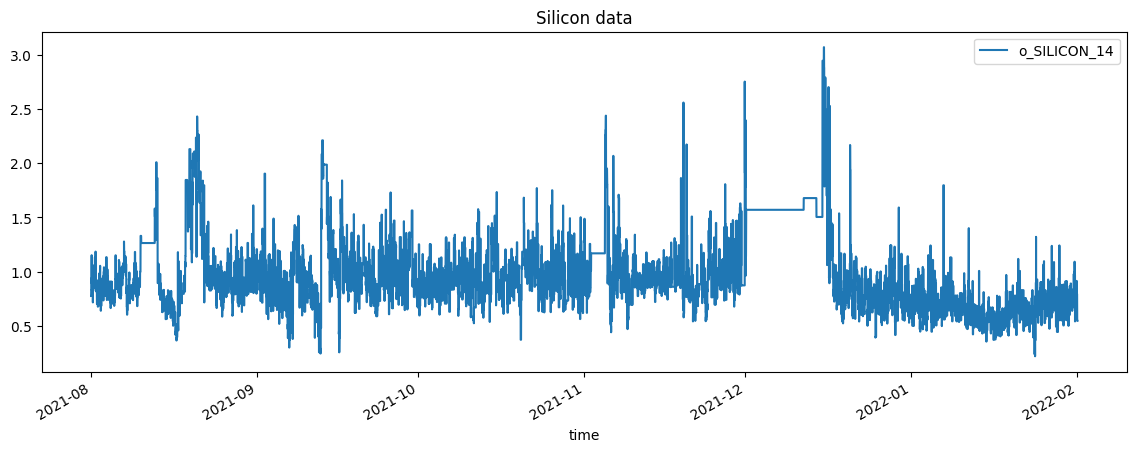

In [54]:

plt.rcParams["figure.figsize"] = [14, 5]  

ts_silicon_data.plot(title='Silicon data')



In [55]:

ts_silicon_data_copy        = ts_silicon_data.copy()


In [56]:

for df in [ts_silicon_data_copy]:
    handle_missing_data(df)


In [57]:

ts_silicon_data_os        = one_step_forecast(ts_silicon_data_copy,        5)


In [58]:

print(       ts_silicon_data_os.shape   )


(265015, 6)


In [59]:

ts_silicon_data_os


x_1    x_2    x_3    x_4    x_5      y
time                                                         
2021-08-01 00:00:00  0.776  0.776  0.776  0.776  0.776  0.776
2021-08-01 00:01:00  0.776  0.776  0.776  0.776  0.776  0.776
2021-08-01 00:02:00  0.776  0.776  0.776  0.776  0.776  0.776
2021-08-01 00:03:00  0.776  0.776  0.776  0.776  0.776  0.776
2021-08-01 00:04:00  0.776  0.776  0.776  0.776  0.776  0.776
...                    ...    ...    ...    ...    ...    ...
2022-01-31 23:50:00  0.547  0.547  0.547  0.547  0.547  0.547
2022-01-31 23:51:00  0.547  0.547  0.547  0.547  0.547  0.547
2022-01-31 23:52:00  0.547  0.547  0.547  0.547  0.547  0.547
2022-01-31 23:53:00  0.547  0.547  0.547  0.547  0.547  0.547
2022-01-31 23:54:00  0.547  0.547  0.547  0.547  0.547  0.547

[265015 rows x 6 columns]

In [60]:

train, test = split_data(ts_silicon_data_os)

print(f'Train: {len(train)} Test: {len(test)}')


Train: 225263 Test: 39752


In [61]:

scaler = Standardize()

train_s, test_s = scaler.fit_transform(train, test)

train_s.head()


x_1       x_2       x_3       x_4      x_5         y
time                                                                          
2021-08-01 00:00:00 -0.742413 -0.742415 -0.742417 -0.742418 -0.74242 -0.742421
2021-08-01 00:01:00 -0.742413 -0.742415 -0.742417 -0.742418 -0.74242 -0.742421
2021-08-01 00:02:00 -0.742413 -0.742415 -0.742417 -0.742418 -0.74242 -0.742421
2021-08-01 00:03:00 -0.742413 -0.742415 -0.742417 -0.742418 -0.74242 -0.742421
2021-08-01 00:04:00 -0.742413 -0.742415 -0.742417 -0.742418 -0.74242 -0.742421


## process starts here


In [62]:

ts_silicon_data_cp = ts_silicon_data.copy()



In [63]:

ts_silicon_data_reg = one_step_forecast(ts_silicon_data_cp, 10)


In [64]:

print(ts_silicon_data_reg.shape)


(265010, 11)


In [65]:

mse  = MeanSquaredError()
mape = MeanAbsolutePercentageError()
mase = MeanAbsoluteScaledError()


In [66]:

train_silicon, test_silicon = split_data(ts_silicon_data_reg, test_split=0.10)
scaler_silicon= Standardize()
train_silicon_s, test_silicon_s = scaler_silicon.fit_transform(train_silicon,test_silicon)


In [67]:

regressors = {
    'Linear Regression': LinearRegression(fit_intercept=False),
    'Elastic Net': ElasticNet(0.5, fit_intercept=False),
    'Ridge Regression': Ridge(0.5, fit_intercept=False),
    'Lasso Regression': Lasso(0.5, fit_intercept=False),
    'Huber Regression': HuberRegressor(fit_intercept=False)}


In [68]:

silicon_results = train_different_models(train_silicon_s, test_silicon_s, regressors)


training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [69]:

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
silicon_results = pd.DataFrame(silicon_results)
silicon_results[cols].sort_values('MASE')


Model Name      RMSE      MAPE       MASE
4   Huber Regression  0.058708  0.021156   1.090750
0  Linear Regression  0.054387  0.021473   1.241199
2   Ridge Regression  0.054389  0.021472   1.241209
1        Elastic Net  0.313038  0.297180  33.082396
3   Lasso Regression  0.551943  0.506617  59.368873

In [70]:

def plot_results_colors(cols, results, data_name):
    for row in results[cols].iterrows():
        yhat, resid, actual, name = row[1]
        plt.title(f'{data_name} - {name}')
        plt.plot(actual, 'k--', alpha=0.5, color='blue')
        plt.plot(yhat, 'k', color='red')
        plt.legend(['actual', 'forecast'])
        plot_acf(resid, zero=False, 
                 title=f'{data_name} - Autocorrelation')
        plt.show()


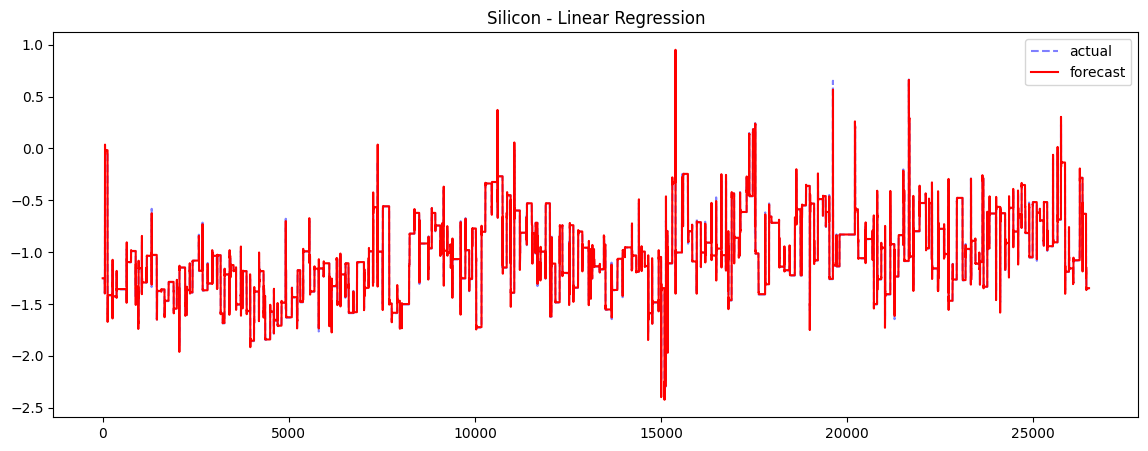

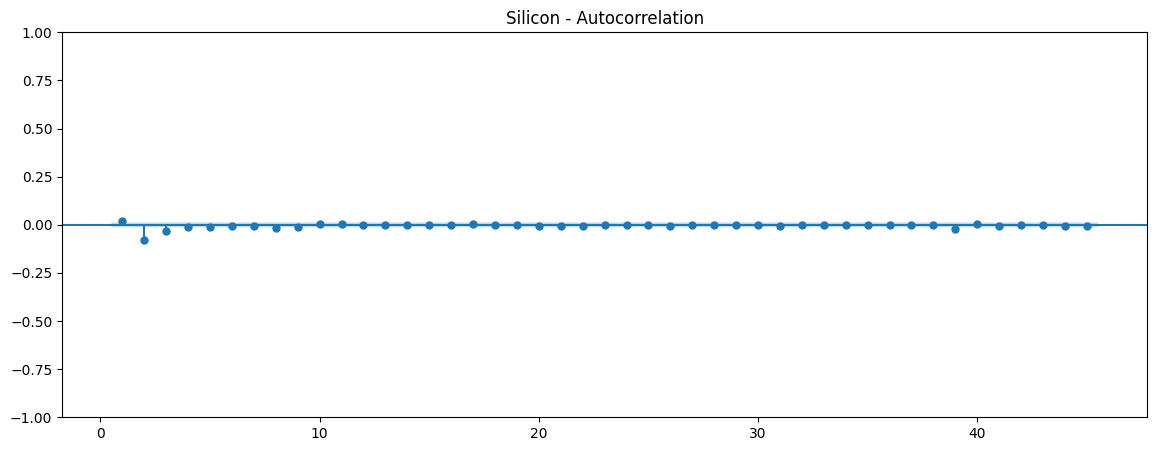

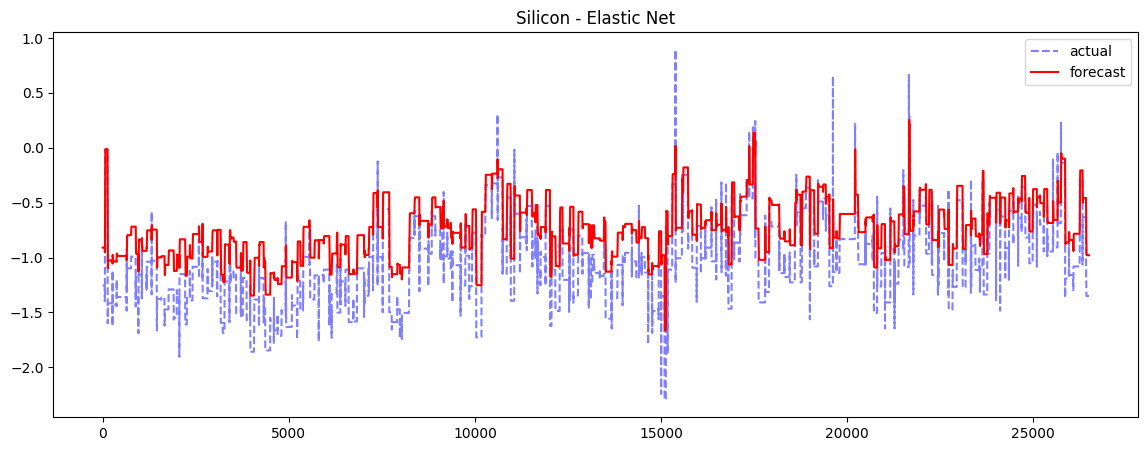

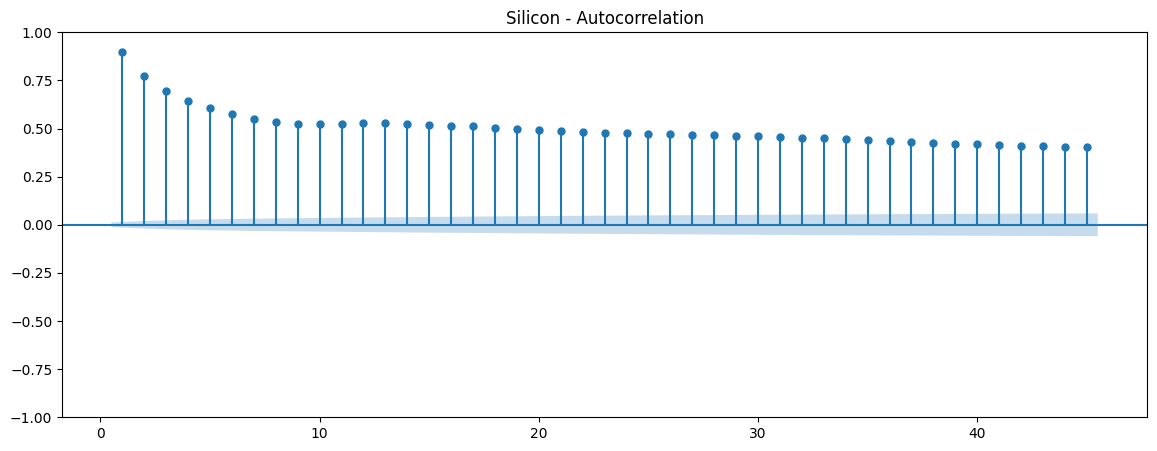

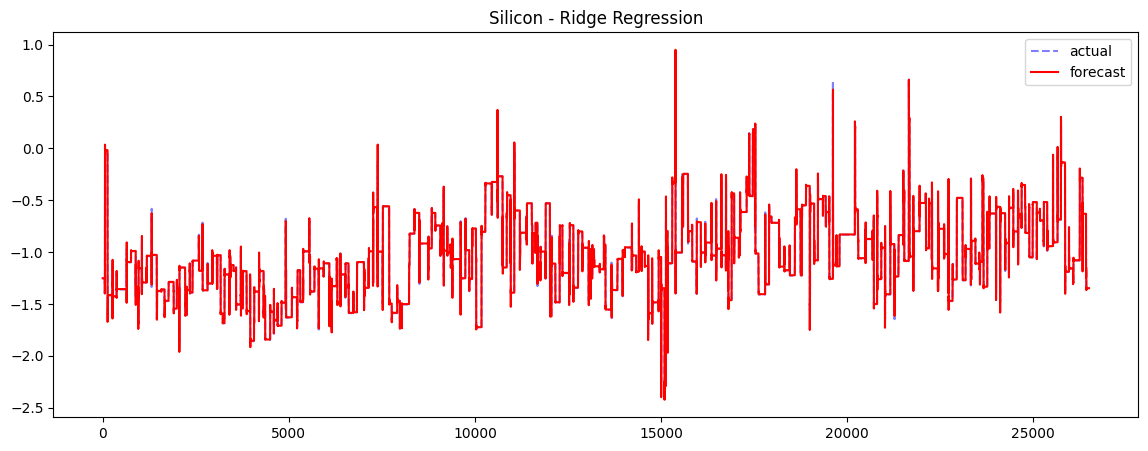

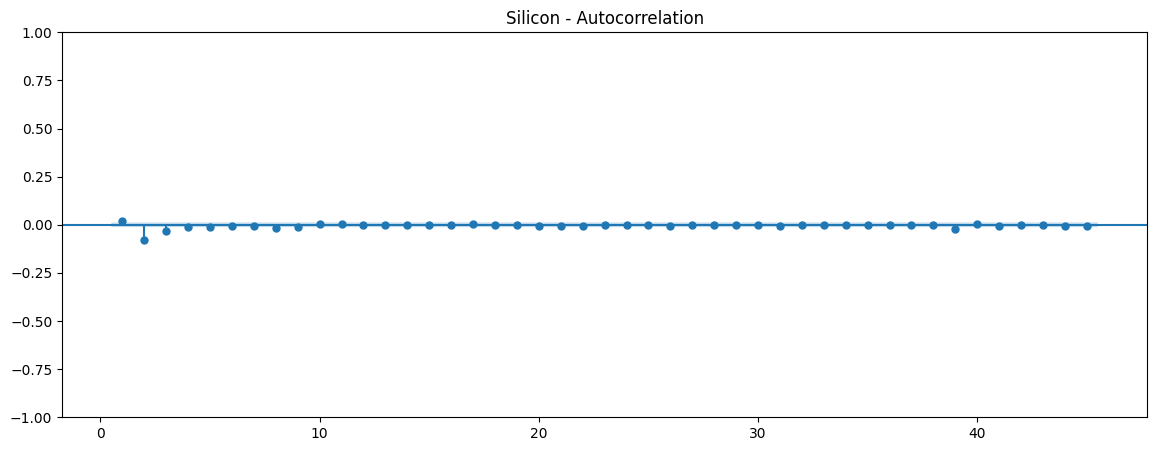

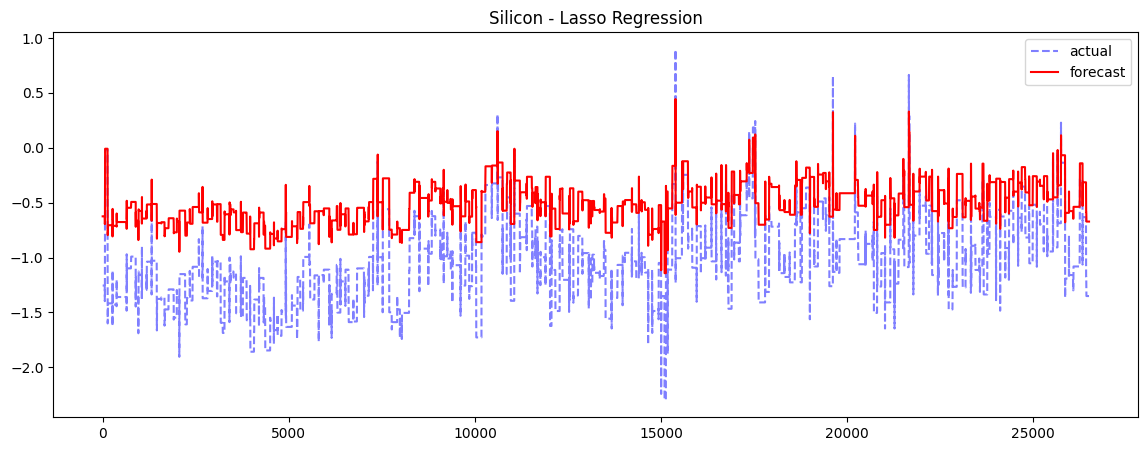

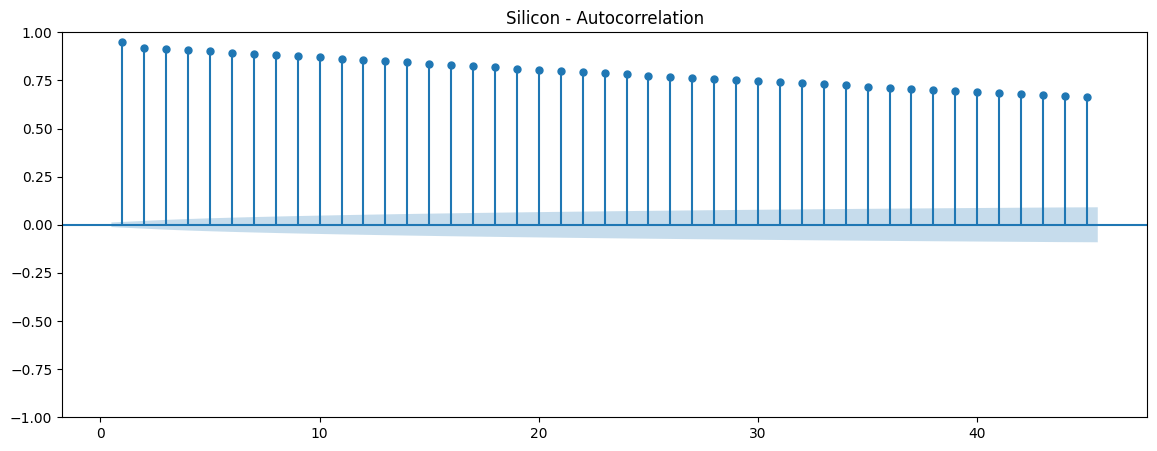

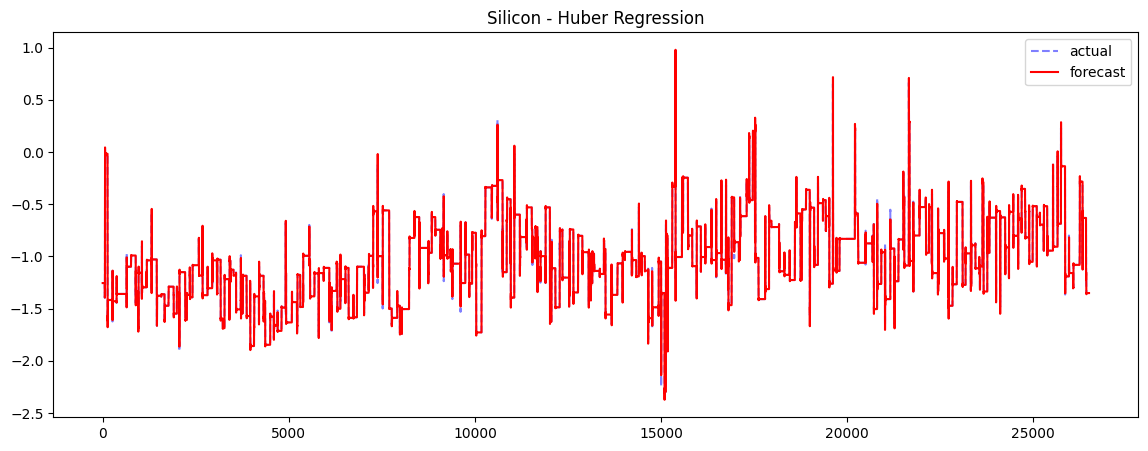

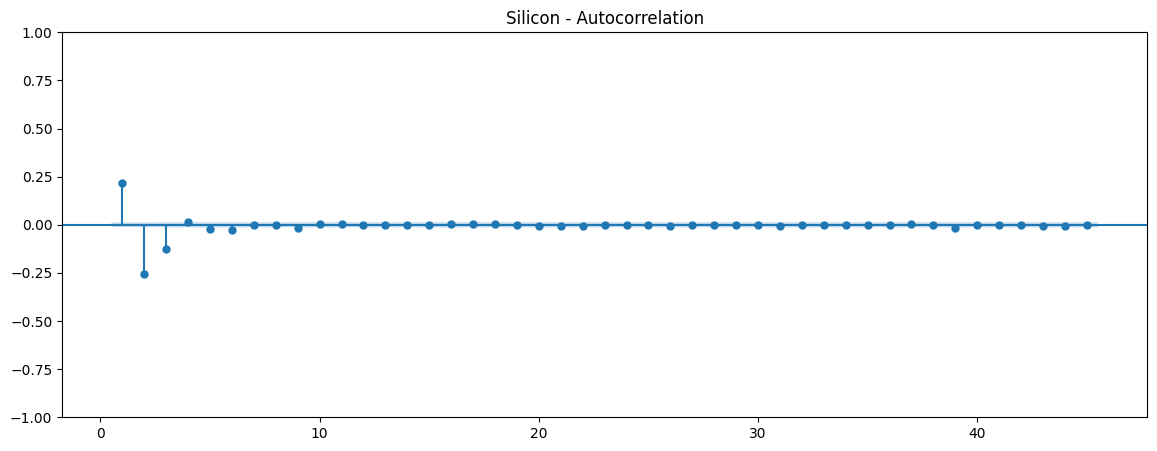

In [71]:

cols = ['yhat', 'resid', 'actual', 'Model Name']

plot_results_colors(cols, silicon_results, 'Silicon')


In [72]:

cols = ['Model Name', 'Model']
silicon_models = silicon_results.iloc[0:4][cols]

for row in silicon_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)


Linear Regression
[-0.00167201 -0.00379968  0.01660659 -0.00389905  0.02289466 -0.02472878
  0.04442625  0.07739873 -0.29264994  1.16317328]
Elastic Net
[0.04715554 0.04983144 0.05333832 0.05759608 0.06292085 0.06949979
 0.0776355  0.08746499 0.10072315 0.11842483]
Ridge Regression
[-0.0016796  -0.00377399  0.01657426 -0.00384246  0.02281943 -0.02464939
  0.04449944  0.07700589 -0.2917062   1.16250145]
Lasso Regression
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.49751009]


In [73]:

ts_silicon_data_reg


x_1    x_2    x_3    x_4    x_5    x_6    x_7    x_8  \
time                                                                          
2021-08-01 00:00:00  0.776  0.776  0.776  0.776  0.776  0.776  0.776  0.776   
2021-08-01 00:01:00  0.776  0.776  0.776  0.776  0.776  0.776  0.776  0.776   
2021-08-01 00:02:00  0.776  0.776  0.776  0.776  0.776  0.776  0.776  0.776   
2021-08-01 00:03:00  0.776  0.776  0.776  0.776  0.776  0.776  0.776  0.776   
2021-08-01 00:04:00  0.776  0.776  0.776  0.776  0.776  0.776  0.776  0.776   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
2022-01-31 23:45:00  0.547  0.547  0.547  0.547  0.547  0.547  0.547  0.547   
2022-01-31 23:46:00  0.547  0.547  0.547  0.547  0.547  0.547  0.547  0.547   
2022-01-31 23:47:00  0.547  0.547  0.547  0.547  0.547  0.547  0.547  0.547   
2022-01-31 23:48:00  0.547  0.547  0.547  0.547  0.547  0.547  0.547  0.547   
2022-01-31 23:49:00  0.547  0.547  0.547  0.547  0.547  0.547  0.547  0.547   

                       x_9   x_10      y  
time                                      
2021-08-01 00:00:00  0.776  0.776  0.776  
2021-08-01 00:01:00  0.776  0.776  0.776  
2021-08-01 00:02:00  0.776  0.776  0.776  
2021-08-01 00:03:00  0.776  0.776  0.776  
2021-08-01 00:04:00  0.776  0.776  0.776  
...                    ...    ...    ...  
2022-01-31 23:45:00  0.547  0.547  0.547  
2022-01-31 23:46:00  0.547  0.547  0.547  
2022-01-31 23:47:00  0.547  0.547  0.547  
2022-01-31 23:48:00  0.547  0.547  0.547  
2022-01-31 23:49:00  0.547  0.547  0.547  

[265010 rows x 11 columns]

In [74]:

silicon_10 = ts_silicon_data_reg[['y', 'x_10']]

train_silicon10, test_silicon10 = split_data(silicon_10, test_split=0.10)
scaler_silicon10 = Standardize()
train_silicon10_s, test_silicon10_s = scaler_silicon10.fit_transform(train_silicon10, test_silicon10)

silicon_10_results = train_different_models(train_silicon10_s, test_silicon10_s, regressors)

cols = ['Model Name', 'RMSE', 'MAPE', 'MASE']
silicon_10_results = pd.DataFrame( silicon_10_results )
silicon_10_results[cols].sort_values('MASE')


training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


Model Name      RMSE      MAPE       MASE
4   Huber Regression  0.056434  0.018406   0.946361
0  Linear Regression  0.056429  0.020715   1.222953
2   Ridge Regression  0.056429  0.020717   1.223186
1        Elastic Net  0.442561  0.407528  47.545751
3   Lasso Regression  0.551943  0.506617  59.368873

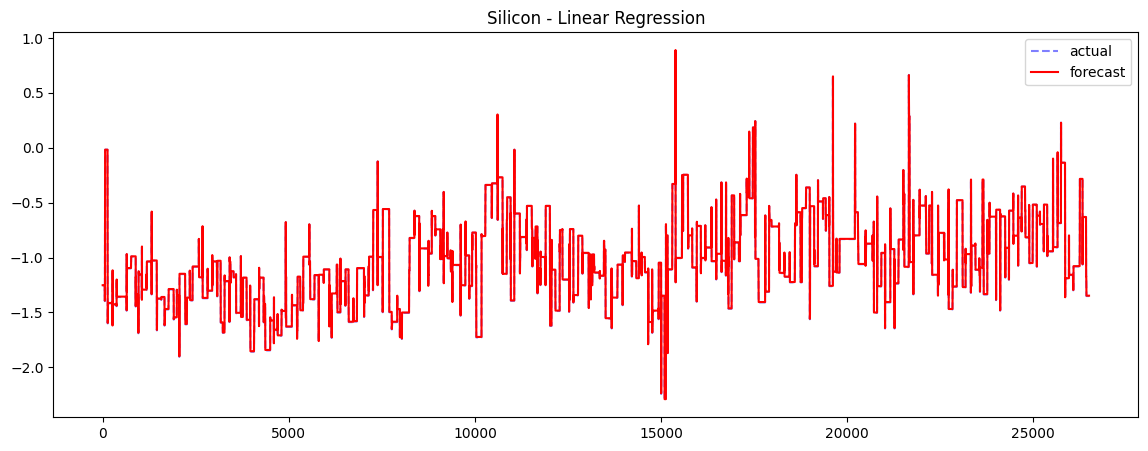

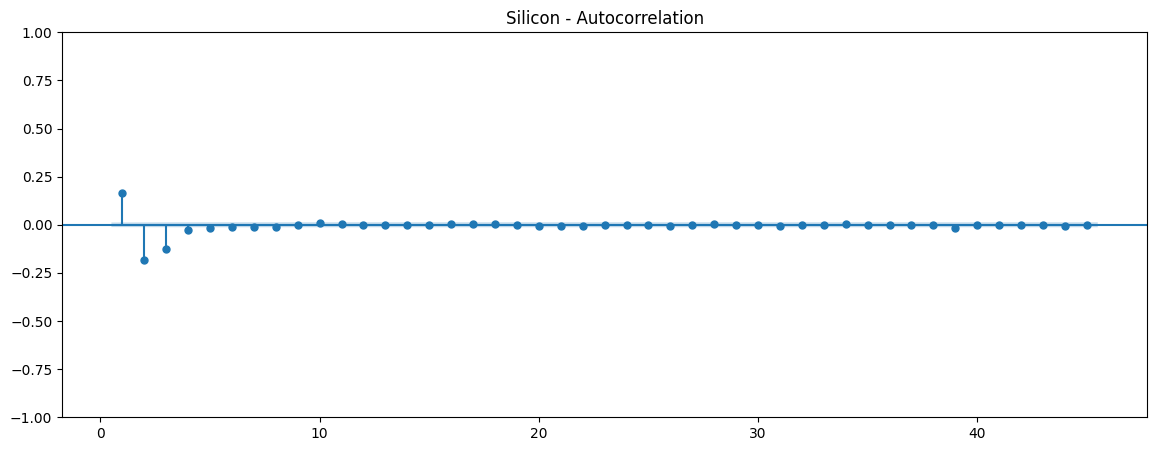

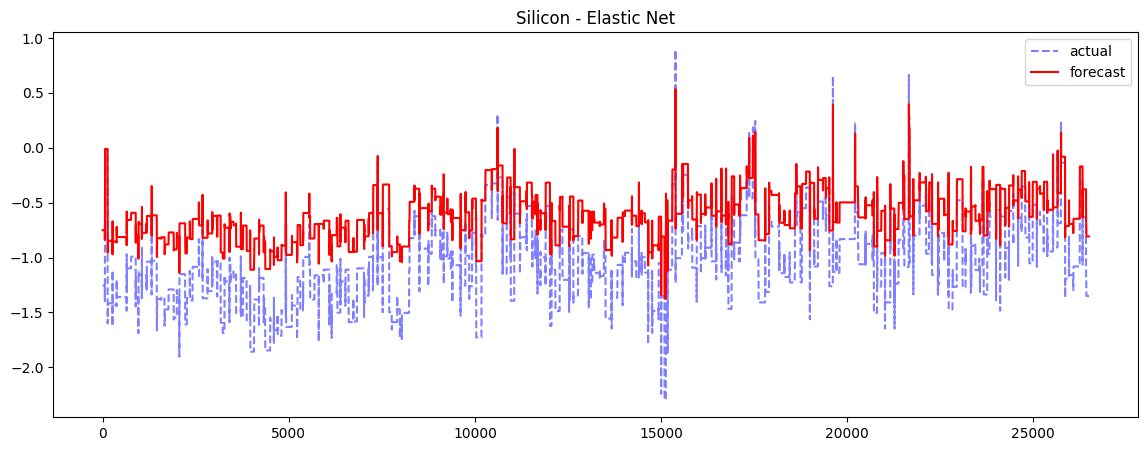

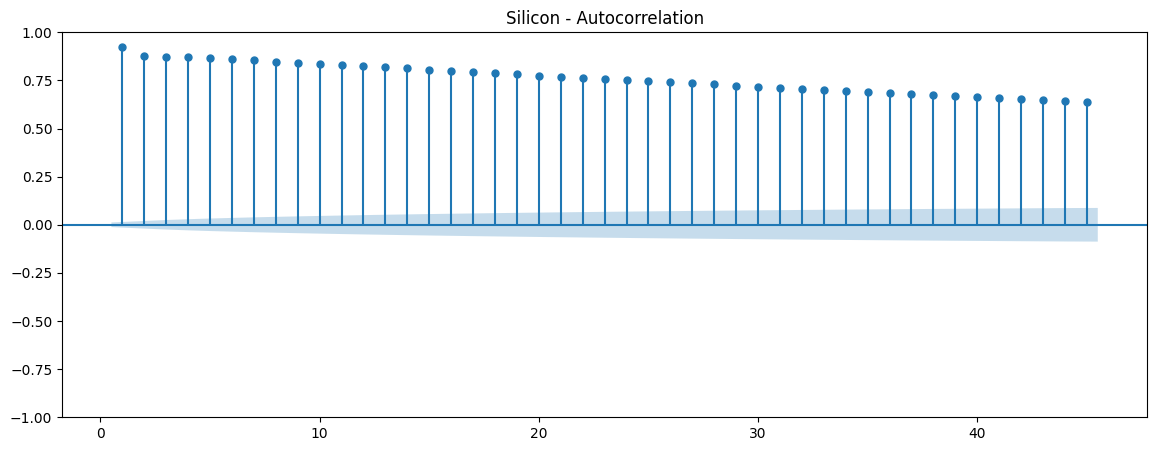

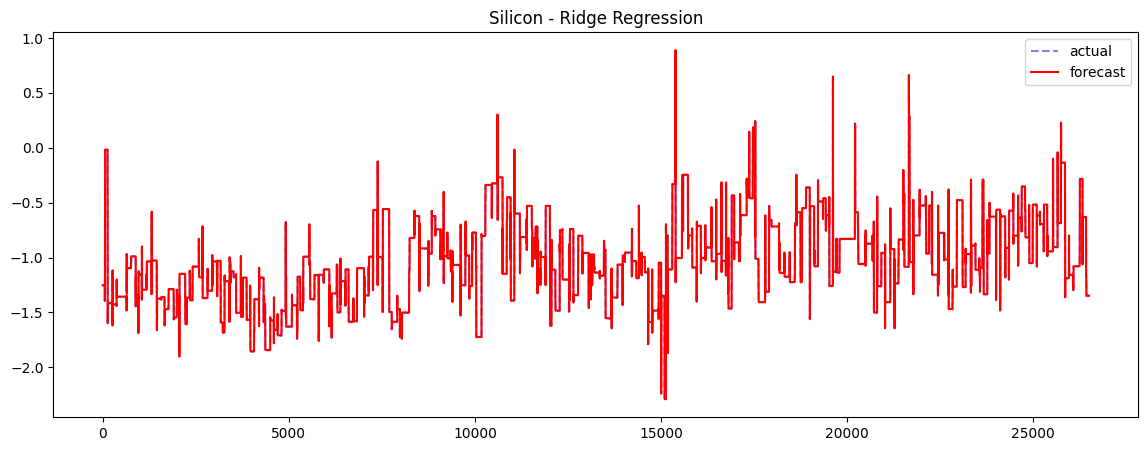

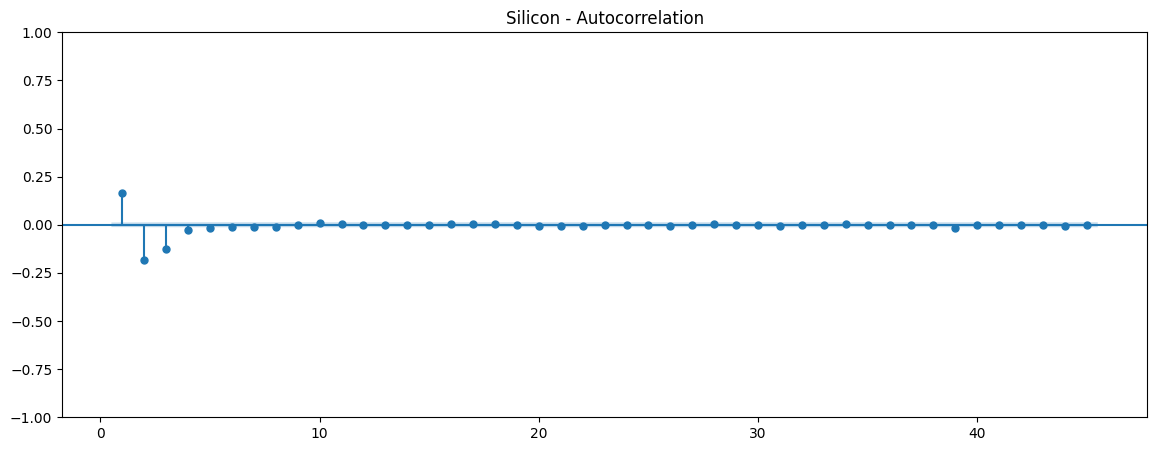

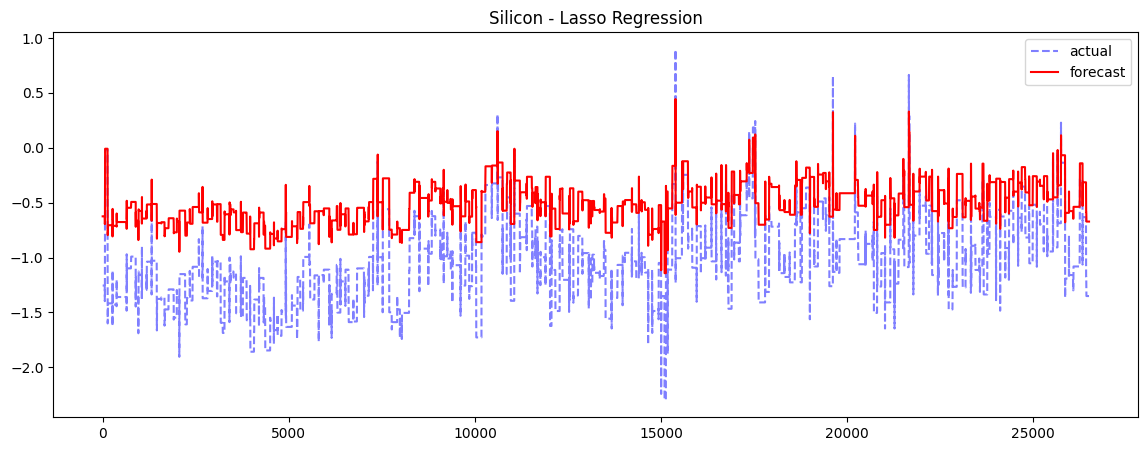

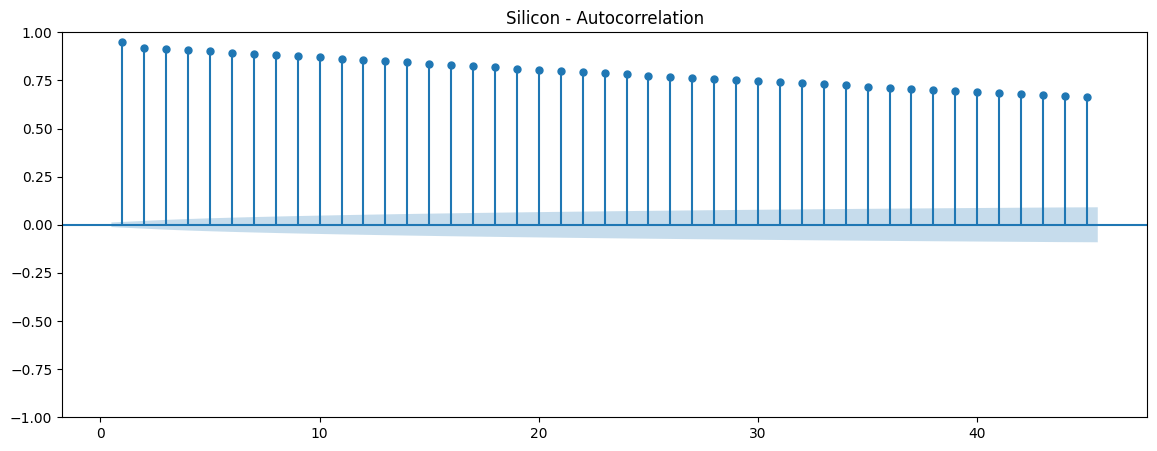

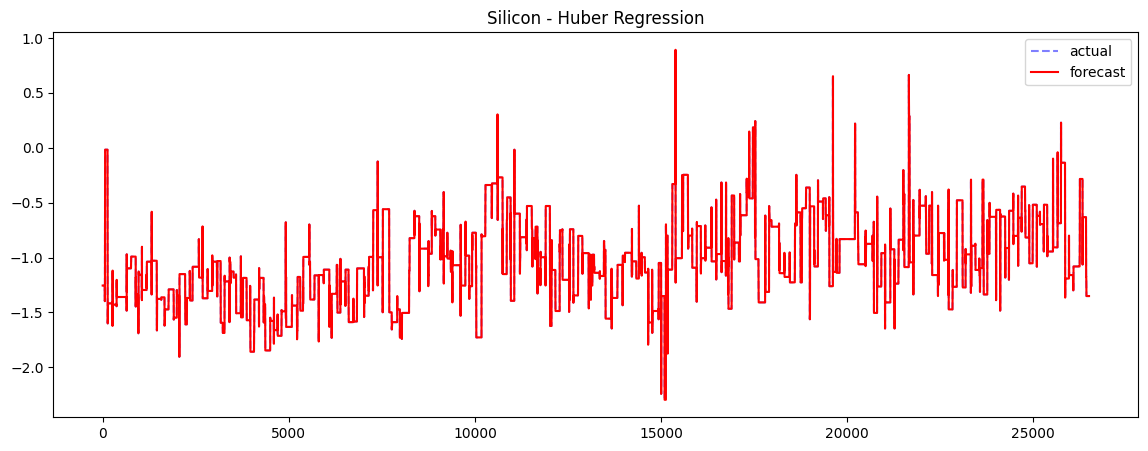

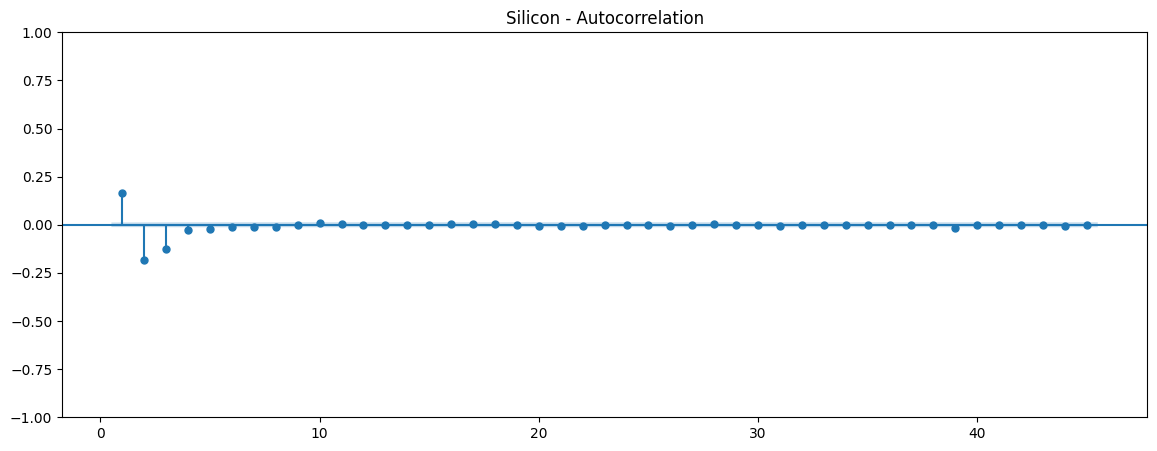

In [75]:

cols = ['yhat', 'resid', 'actual', 'Model Name']
plot_results_colors(cols, silicon_10_results, 'Silicon')


In [76]:

cols = ['Model Name', 'Model']
silicon_models = silicon_10_results.iloc[0:4][cols]

for row in silicon_models.iterrows():
    print(row[1][0])
    print(row[1][1].coef_)


Linear Regression
[0.99751218]
Elastic Net
[0.59800841]
Ridge Regression
[0.99751009]
Lasso Regression
[0.49751009]



## Multi-Step Forecasting using Linear Regression Models with Scikit-Learn


In [77]:

silicon_results = train_different_models( train_silicon_s, test_silicon_s, regressors )


training Linear Regression ...
training Elastic Net ...
training Ridge Regression ...
training Lasso Regression ...
training Huber Regression ...


In [78]:

silicon_results = pd.DataFrame(silicon_results)


In [79]:

silicon_results


Model Name                                       Model      RMSE  \
0  Linear Regression       LinearRegression(fit_intercept=False)  0.054387   
1        Elastic Net  ElasticNet(alpha=0.5, fit_intercept=False)  0.313038   
2   Ridge Regression       Ridge(alpha=0.5, fit_intercept=False)  0.054389   
3   Lasso Regression       Lasso(alpha=0.5, fit_intercept=False)  0.551943   
4   Huber Regression         HuberRegressor(fit_intercept=False)  0.058708   

       MAPE       MASE                                               yhat  \
0  0.021473   1.241199  [-1.2517657435245015, -1.2517657435245015, -1....   
1  0.297180  33.082396  [-0.9090766342800236, -0.9090766342800236, -0....   
2  0.021472   1.241209  [-1.2517642219100198, -1.2517642219100198, -1....   
3  0.506617  59.368873  [-0.6241702825143705, -0.6241702825143705, -0....   
4  0.021156   1.090750  [-1.2545855167974536, -1.2545855167974536, -1....   

                                               resid  \
0  [-0.0028171724269945297, -0.002817172426994529...   
1  [-0.34550628167147246, -0.34550628167147246, -...   
2  [-0.0028186940414762773, -0.002818694041476277...   
3  [-0.6304126334371256, -0.6304126334371256, -0....   
4  [2.6008459574899945e-06, 2.6008459574899945e-0...   

                                              actual  
0  [-1.254582915951496, -1.254582915951496, -1.25...  
1  [-1.254582915951496, -1.254582915951496, -1.25...  
2  [-1.254582915951496, -1.254582915951496, -1.25...  
3  [-1.254582915951496, -1.254582915951496, -1.25...  
4  [-1.254582915951496, -1.254582915951496, -1.25...

In [80]:

test_silicon_s.iloc[[-1]]


x_1       x_2       x_3       x_4      x_5  \
time                                                                   
2022-01-31 23:49:00 -1.350272 -1.350267 -1.350261 -1.350256 -1.35025   

                          x_6       x_7       x_8       x_9      x_10  \
time                                                                    
2022-01-31 23:49:00 -1.350245 -1.350239 -1.350234 -1.350228 -1.350223   

                            y  
time                           
2022-01-31 23:49:00 -1.350217

In [81]:

models = silicon_results[['Model Name','Model']]
models


Model Name                                       Model
0  Linear Regression       LinearRegression(fit_intercept=False)
1        Elastic Net  ElasticNet(alpha=0.5, fit_intercept=False)
2   Ridge Regression       Ridge(alpha=0.5, fit_intercept=False)
3   Lasso Regression       Lasso(alpha=0.5, fit_intercept=False)
4   Huber Regression         HuberRegressor(fit_intercept=False)

In [82]:

# another version using NumPy
# def multi_step_forecast(data, model, steps=10):
#     forecast = []
#     for i in range(steps):
#         one_step_pred = model.predict(data.reshape(1,-1))[0]
#         forecast.append(one_step_pred)
#         data = np.roll(data, shift=-1)
#         data[-1] = one_step_pred
#     return np.array(forecast)


In [83]:

def multi_step_forecast(data, model, steps=10):
    forecast = []
    for i in range(steps):
        one_step_pred = model.predict(np.array(data).reshape(1,-1))[0]
        forecast.append(one_step_pred)
        _ = data.pop(0)
        data.append(one_step_pred)
    return np.array(forecast)


In [84]:

frcst_silicon = {}

models = silicon_results[['Model Name','Model']]

silicon_ms = test_silicon_s.drop(columns=['y']).iloc[-1].tolist()

for i in models.iterrows():
    pred = multi_step_forecast(silicon_ms, steps=10, model=i[1]['Model'])
    pred = scaler_silicon.inverse_y(pred)
    frcst_silicon[i[1]['Model Name']] = pred  


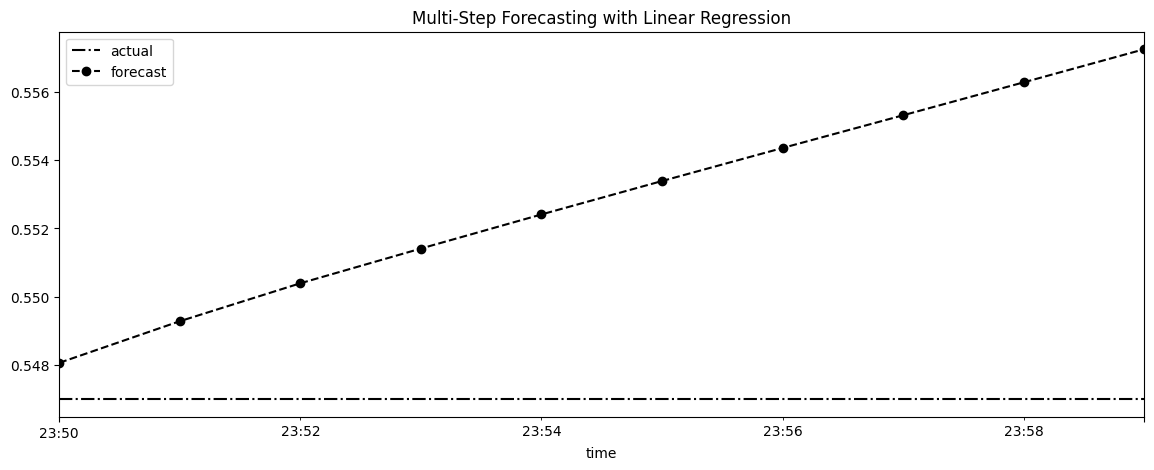

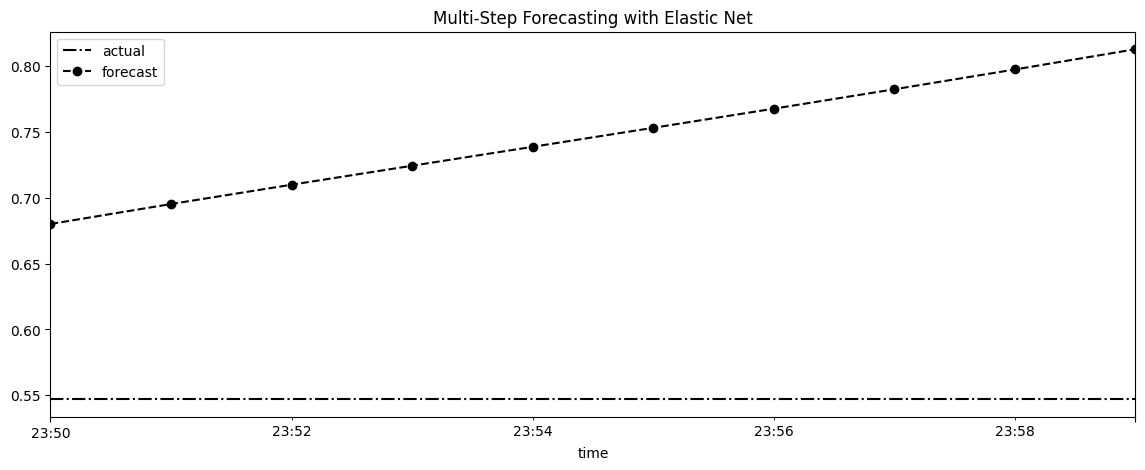

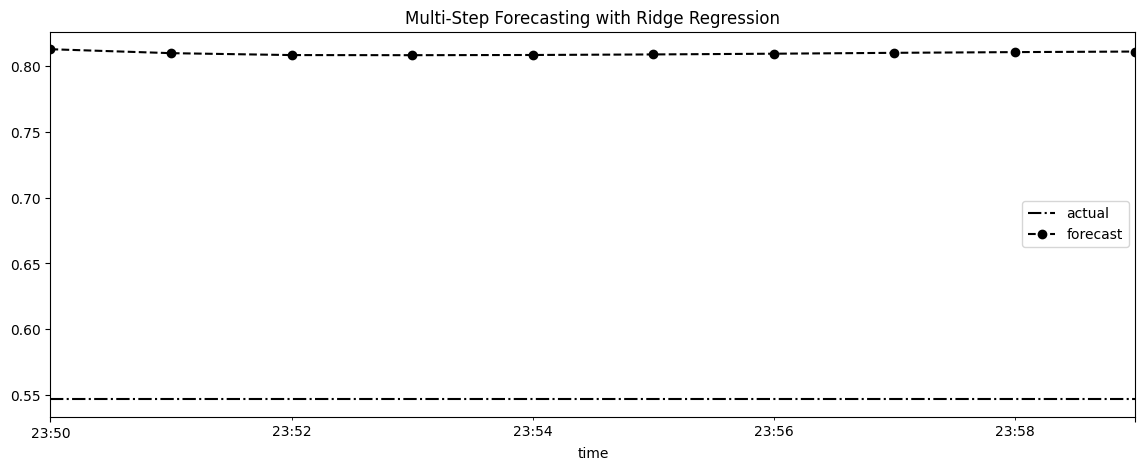

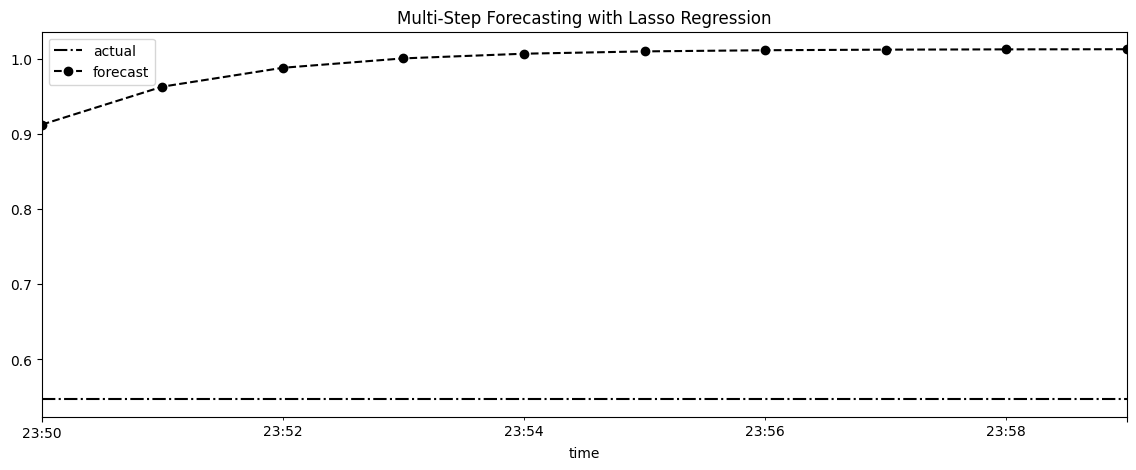

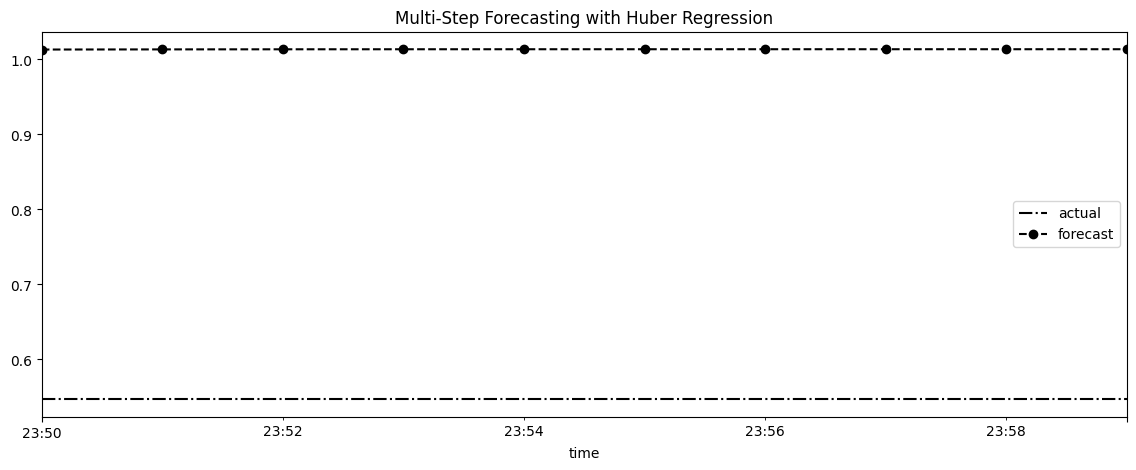

In [85]:

for name, pred in frcst_silicon.items():
    actual = ts_silicon_data_cp.iloc[-10:]
    ax = actual.plot(style='k-.')
    pd.Series(pred, index=ts_silicon_data_cp.index[-10:]).plot(style='k--o', ax=ax)
    plt.title(f'Multi-Step Forecasting with {name}')
    plt.legend(['actual', 'forecast'])
    plt.show()



## Multiple inputs and outputs


In [86]:

def multiple_output(df, window_in, window_out):
    d = df.values
    x = []
    y = []
    n = len(df)
    idx = df.index[:-window_in]
    print(len(idx))
    for start in range(n-window_in):
        end = start + window_in
        out = end + window_out
        x.append(d[start:end].ravel())
        y.append(d[end:out].ravel())
        
    cols_x = [f'x_{i}' for i in range(1, window_in+1)]
    cols_y = [f'y_{i}' for i in range(1, window_out+1)]

    df_xs = pd.DataFrame(x,  index=idx, columns=cols_x)
    df_y = pd.DataFrame(y,index=idx, columns=cols_y)
    return pd.concat([df_xs, df_y], axis=1).dropna()


In [87]:

win_in, win_out = 10, 10
silicon_mo = multiple_output(ts_silicon_data_cp, win_in, win_out)

train_silicon, test_silicon = split_data(silicon_mo, test_split=0.10)
scaler_silicon = Standardize()
train_silicon_s, test_silicon_s = scaler_silicon.fit_transform(train_silicon,test_silicon)


265010


In [88]:

silicon_mo.columns


Index(['x_1', 'x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'x_7', 'x_8', 'x_9', 'x_10',
       'y_1', 'y_2', 'y_3', 'y_4', 'y_5', 'y_6', 'y_7', 'y_8', 'y_9', 'y_10'],
      dtype='object')

In [89]:

train_silicon_s.shape


(238501, 20)

In [90]:

lr = LinearRegression()


In [91]:

X_train, y_train = train_silicon_s.iloc[: , :win_in], train_silicon_s.iloc[:, win_out:]
X_test, y_test   = test_silicon_s.iloc[: , :win_in], test_silicon_s.iloc[:, win_out:]


In [92]:

lr.fit(X_train, y_train)


LinearRegression()

In [93]:

mo_pred = scaler_silicon.inverse_y(lr.predict(X_test)[-1])
dates   = pd.date_range('2021-08-13', freq='D', periods=20)
inputs, outputs = dates[:win_in], dates[win_out:]


In [94]:

test_silicon.iloc[-1].values.shape


(20,)

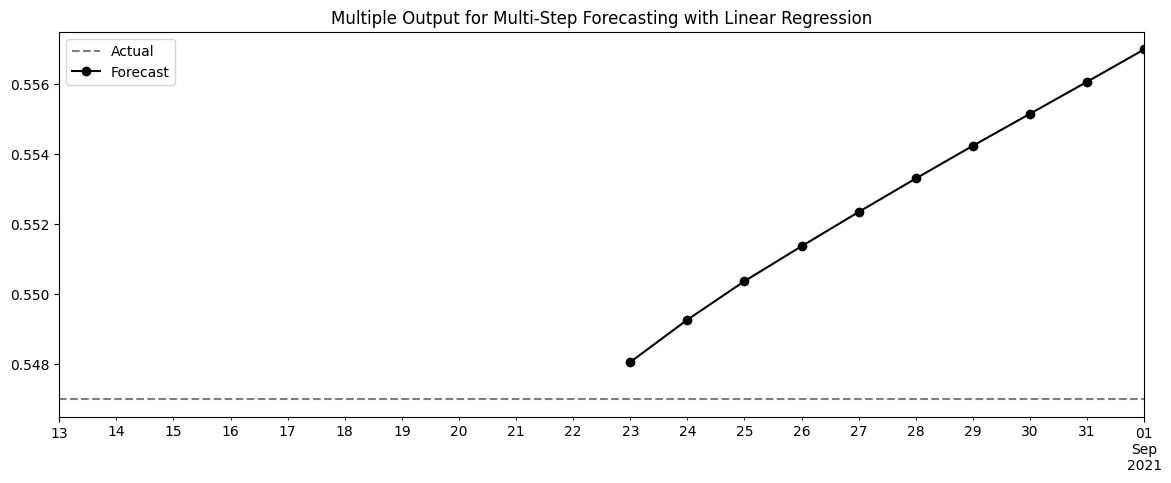

In [95]:

pd.Series(test_silicon.iloc[-1].values, index=dates).plot(style='k--', alpha=0.5)
pd.Series(mo_pred, index=outputs).plot(style='k-o')

plt.title('Multiple Output for Multi-Step Forecasting with Linear Regression')
plt.legend(['Actual', 'Forecast'])

#plt.savefig('../../../Packt-Time-Series-Cookbook/Chapters/Ch12/images/fig_12.10.png', bbox_inches='tight', dpi=600)
